# Analysis of differential cell abundance in time - Myeloid cells

In this notebook we test for differential abundance in immune cell populations using [Milo](https://www.biorxiv.org/content/10.1101/2020.11.23.393769v1) (python implementation [milopy](https://github.com/emdann/milopy))

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os,sys
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.sparse
import anndata
import seaborn as sns
import scvelo as scv

import milopy.core as milo
import milopy.plot as milopl

In [3]:
## import project utils
cwd = '../utils/'
sys.path.append(cwd)

import genes
import panfetal_utils

In [4]:
figdir = "/home/jovyan/mount/gdrive/Pan_fetal/Updates_and_presentations/figures/milo_analysis_MYELOID/"
if os.path.exists(figdir):
    sc.settings.figdir = figdir
else:
    os.mkdir(figdir)
    sc.settings.figdir = figdir

In [5]:
## r2py setup
import anndata2ri
import rpy2.rinterface_lib.callbacks
import logging
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

anndata2ri.activate()

In [6]:
%load_ext rpy2.ipython


In [7]:
%%R
library(tidyverse)
library(reshape2)
library(patchwork)

remove_x_axis <- function(){
  theme(axis.text.x = element_blank(), axis.ticks.x = element_blank(), axis.title.x = element_blank())  
}

remove_y_axis <- function(){
  theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), axis.title.y = element_blank())  
}

In [8]:
import milopy

def annotate_nhoods(adata, anno_col):
    anno_dummies = pd.get_dummies(adata.obs[anno_col])
    anno_count = adata.obsm["nhoods"].T.dot(scipy.sparse.csr_matrix(anno_dummies.values))
    anno_frac = np.array(anno_count/anno_count.sum(1))

    anno_frac = pd.DataFrame(anno_frac, 
                             columns=anno_dummies.columns,
                             index=adata.uns["nhood_adata"].obs_names
                            )
    adata.uns["nhood_adata"].obsm["frac_annotation"] = anno_frac.values
    adata.uns["nhood_adata"].uns["annotation_labels"] = anno_frac.columns
    adata.uns["nhood_adata"].obs["nhood_annotation"] = anno_frac.idxmax(1)
    adata.uns["nhood_adata"].obs["nhood_annotation_frac"] = anno_frac.max(1)

## Load data

In [9]:
data_dir="/nfs/team205/ed6/data/Fetal_immune/"
timestamp="20210429"
split="MYELOID_V2"

In [12]:
adata = sc.read_h5ad(data_dir + 'PAN.A01.v01.entire_data_normalised_log.{t}.{s}.embedding.h5ad'.format(t=timestamp, s=split))
adata.var_names_make_unique()

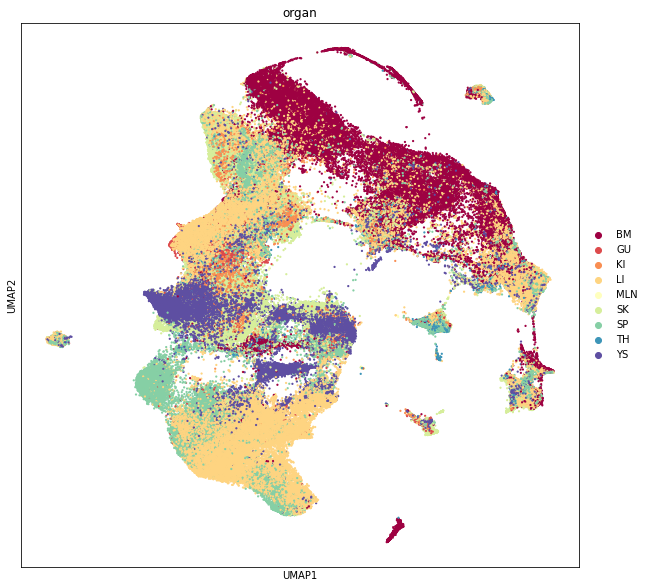

In [13]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color="organ", palette="Spectral", size=20)

In [14]:
## Filter maternal contaminants
mat_barcodes = pd.read_csv("~/Pan_fetal_immune/metadata/souporcell_results/maternal_barcodes.csv", index_col=0)
mat_barcodes["x"] = pd.Series([x.split("-1")[0] for x in mat_barcodes['x']])

adata = adata[~adata.obs_names.isin(mat_barcodes["x"])]

### Load annotations

In [156]:
anno_obs = pd.read_csv(data_dir + "PAN.A01.v01.entire_data_normalised_log.20210429.full_obs.annotated.clean.csv", index_col=0)
adata = adata[adata.obs_names.isin(anno_obs.index)].copy()
adata.obs["anno_lvl_2_final_clean"] = anno_obs.loc[adata.obs_names]["anno_lvl_2_final_clean"]

In [157]:
ct_counts = adata.obs['anno_lvl_2_final_clean'].value_counts()

saving figure to file ./figures/scvelo_myeloid_anno.png


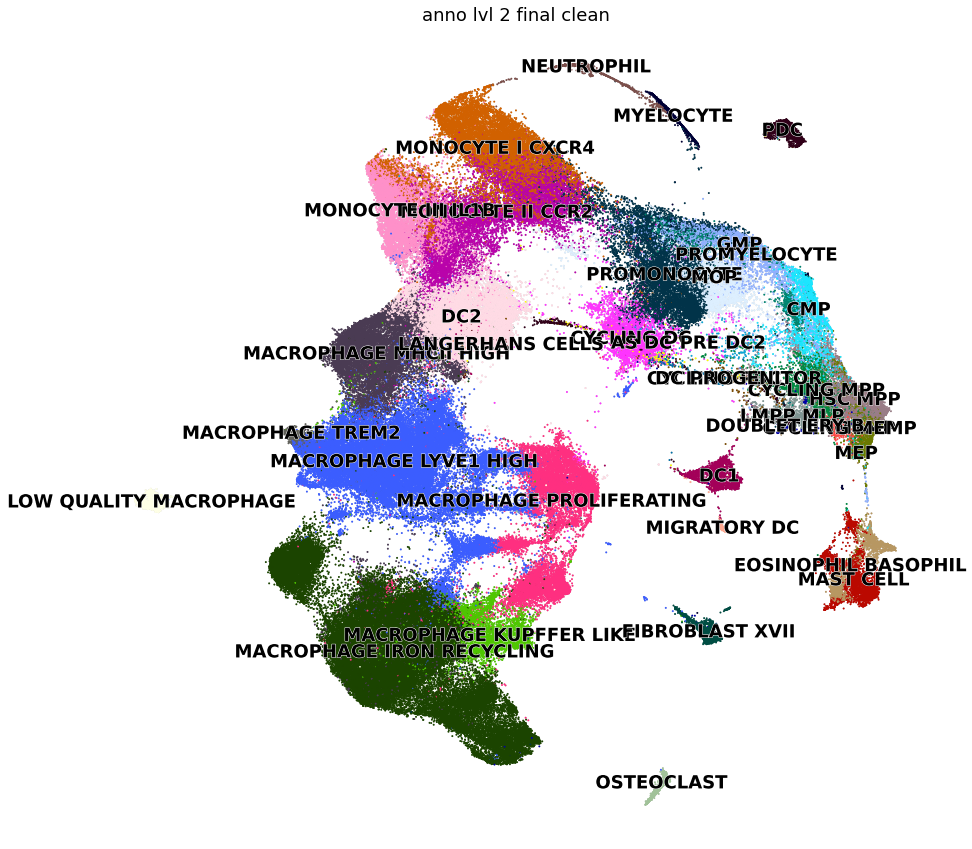

In [158]:
sns.set_context("talk")
plt.rcParams["figure.figsize"] = [15,15]
scv.pl.umap(adata, color="anno_lvl_2_final_clean", size=15, legend_loc="on data",
           groups=ct_counts[ct_counts > 10].index.tolist(), save="myeloid_anno.png")

## Accounting for bias in FACS sorting
Load CD45+/- proportions, provided by Isaac

In [269]:
facs_prop_df = pd.read_csv("/home/jovyan/mount/gdrive/Pan_fetal/meta_share/220621_FACs_gating_proportions_correct.csv")

## Keep only CD45+ and CD45- cells
facs_prop_df = facs_prop_df[facs_prop_df["sort.ids"].isin(["CD45+", "CD45-"])]

## Distinguish tissues where there have been multiple sorts by the no of total events 
facs_prop_df["sort_sample_id"] = facs_prop_df.origin + "_" + facs_prop_df["orig.ident"] + "_" + facs_prop_df.total_live_events.astype("str")

In [267]:
## Add to obs and visualize on UMAP
obs_names = adata.obs.index.copy()
new_obs = pd.merge(adata.obs, facs_prop_df, how="left", indicator=True)
new_obs.index = obs_names

adata.obs = new_obs.drop("_merge", 1).copy()

In [ ]:
plt.rcParams["figure.figsize"] = [10,10]
sc.pl.umap(adata, color=["sort.ids","parent_Multiplier"], size=3)

### Pre-processing for differential abundance testing

We bin gestational ages in 6 windows of 2 weeks length.

In [133]:
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']
cut_bins = [0, 8, 10, 12, 14, 16, 18]

adata.obs["age_bins"] = pd.cut(adata.obs["age"], bins=cut_bins, labels=cut_labels_4).astype("str")
adata.obs["age_bins"] = pd.Categorical(adata.obs["age_bins"], categories=cut_labels_4, ordered=True)
adata.obs["age_bins"]

## Convert covariate to continous
adata.obs['age_bins'] = adata.obs['age_bins'].cat.codes

We keep cells sorted for CD45+, CD45- or total.

In [21]:
### Fix sort ids
adata.obs["Sort_id"] = ["CD45P" if x == "CD45P_CD45N" else x for x in adata.obs["Sort_id"]]
adata.obs["Sort_id"] = ["CD45N" if x == "CD45EN" else x for x in adata.obs["Sort_id"]]

### Exclude cells from unconventional sorts
adata = adata[adata.obs["Sort_id"].isin(["CD45P", "CD45N", "TOT"])]
### Exclude CD45P/N cells that don't have true fraction quantification
# (mainly Gut, ask Rasa)
adata = adata[~(adata.obs["Sort_id"].isin(["CD45P", "CD45N"]) & adata.obs["sort.ids"].isna())]

In [22]:
## Recompute KNN graph
sc.pp.neighbors(adata, use_rep = "X_scvi", n_neighbors = 30, key_added="scvi")

In [23]:
## Construct neighbourhoods
milo.make_nhoods(adata, neighbors_key="scvi", prop=0.05)

## Count cells in neighbourhoods
milo.count_nhoods(adata, sample_col="Sample.lanes")

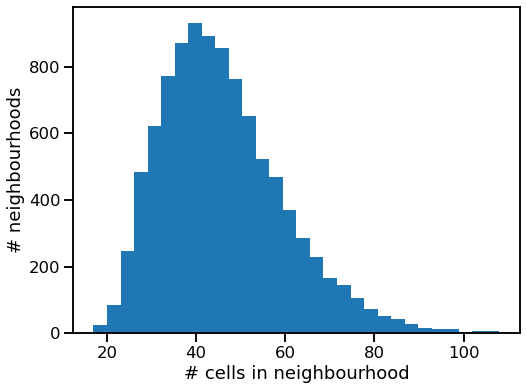

In [134]:
sns.set_context("talk")
plt.rcParams["figure.figsize"] = [8,6]
plt.hist(np.array(adata.obsm['nhoods'].sum(0)).ravel(), bins=30);
plt.xlabel('# cells in neighbourhood'); plt.ylabel('# neighbourhoods');
plt.savefig(figdir+'nhood_size_hist.pdf',bbox_inches='tight');

### Calculate correction factor for each sample

We define the correction factor as 

$$ f_{n} = \log \frac{p_n \cdot \sum_n{S_n}}{S_n} $$

where $p_n$ represents the true proportion of cells from sort $n$ in the tissue samples (column `parent_Multiplier` in FACS table), and $S_n$ represents the total number of cells in sort $n$ (of note, this doesn't coincide with the sum of all $c_{n,i}$ since the same cell can be included in multiple neighbourhoods).

For the unsorted samples we set the correction factor to 0.

In [125]:
import milopy
def _add_FACS_correction_factor(adata):
    milopy.utils.add_covariate_to_nhoods_var(adata,["parent_Multiplier", "sort.ids", 'donor', 'sort_sample_id'])
    nhood_adata = adata.uns["nhood_adata"].copy()
    ## Keep only samples with CD45+/CD45- ratio information
    nhood_adata = nhood_adata[:,nhood_adata.var["sort.ids"].isin(["CD45+", "CD45-"])]
    ## Exclude neighbourhoods that are empty after filtering
    nhood_adata = nhood_adata[nhood_adata.X.sum(1) > 0]
    ## Apply correction
    X_counts = nhood_adata.X.toarray()
    adata.obs["n_sort"] = adata.obs["sort_sample_id"].astype("str") + "_" + adata.obs["sort.ids"].astype("str")
    nhood_adata.var["n_sort"] = nhood_adata.var["sort_sample_id"].astype("str") + "_" + nhood_adata.var["sort.ids"].astype("str")
    sum_i_c_n = adata.obs["n_sort"].value_counts()[nhood_adata.var["n_sort"]].values
    p = nhood_adata.var["parent_Multiplier"].astype("float").values
    sum_S = adata.obs["sort_sample_id"].value_counts()[nhood_adata.var["sort_sample_id"]].values
    count_correction_fact = (p * sum_S)/sum_i_c_n
    fact_correction_df = pd.DataFrame([count_correction_fact, nhood_adata.var_names]).T
    
    fact_correction_df.columns = ["correction_factor", "Sample.lanes"]
    new_obs = pd.merge(adata.obs, fact_correction_df,how="left")
    new_obs.index = adata.obs_names
    adata.obs = new_obs.copy()
    adata.obs["correction_factor"]= adata.obs["correction_factor"].astype("float64")
    adata.obs["correction_factor"] = np.log10(adata.obs["correction_factor"])
    return(adata, count_correction_fact)

In [136]:
## Add correction factor
if "correction_factor" in adata.obs.columns:
    adata.obs = adata.obs.drop("correction_factor",1)
    del adata.uns["nhood_adata"].var["correction_factor"]
adata,fact = _add_FACS_correction_factor(adata)
## Set factor to 0 for unsorted samples
adata.obs.loc[adata.obs["Sort_id"]=="TOT","correction_factor"] = 0

Trying to set attribute `.var` of view, copying.


In [137]:
import milopy.core as milo
def _milo_test_by_organ(adata, design="~ Sort_id + age_bins", sample_col="Sample.lanes", test_organs = None):  
    if test_organs is None:
        ## Keep organs covering at least two time-points
        df = adata.obs[["organ",sample_col, "age_bins"]].drop_duplicates()
        df = df.groupby(["organ","age_bins"]).count().reset_index().pivot("organ",columns="age_bins")
        sampled_organs = df.index[(df > 0).sum(1) > 2]
    else:
        sampled_organs = test_organs

    ## Calculate logFC and SpatialFDR within each organ
    milo_res_dict = {}
    for org in sampled_organs:
        print(org)
        org_samples = adata.obs[adata.obs["organ"] == org][sample_col].unique()
        milo.DA_nhoods(adata, design=design, subset_samples=org_samples)
        milo_res_dict[org] = adata.uns["nhood_adata"].obs.copy()

    ## Collapse results
    logFC_df_ls = [v["logFC"] for k,v in milo_res_dict.items()]
    for k,v in milo_res_dict.items():
        milo_res_dict[k]["logFC_" + k] = milo_res_dict[k]["logFC"].copy()
        milo_res_dict[k]["SpatialFDR_" + k] = milo_res_dict[k]["SpatialFDR"].copy()

    org_fc = pd.concat([v[["logFC_" + k]] for k,v in milo_res_dict.items()], 1)
    org_fdr = pd.concat([v[["SpatialFDR_" + k]] for k,v in milo_res_dict.items()], 1)
    return(milo_res_dict, org_fc, org_fdr)

In [ ]:
adata.obs['age_bins'] = adata.obs['age_bins'].cat.codes
milopy.utils.add_covariate_to_nhoods_var(adata, ['age_bins'])
# adata.uns['nhood_adata'].var['age_bins'] = adata.uns['nhood_adata'].var['age_bins'].cat.codes
adata.uns['nhood_adata'].var['age_bins'] 

In [146]:
milo_res_2, org_fc_2, org_fdr_2 = _milo_test_by_organ(adata, 
                                                      design="~ correction_factor + age_bins",
                                                      test_organs = ["BM", "LI", "SK", "SP", "TH"]
                                                     )

BM
LI
SK
SP
TH


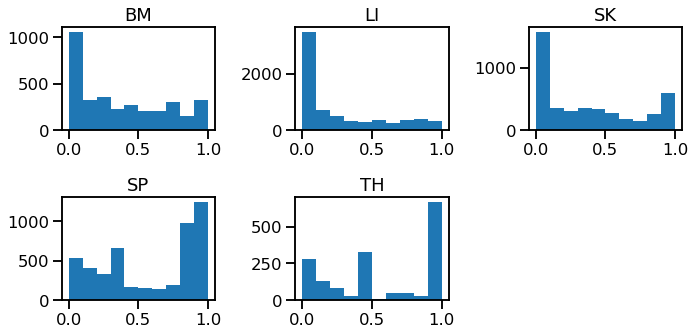

In [147]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res_2.keys():
    plt.subplot(2,3,i)
    plt.hist(milo_res_2[k].PValue);
    plt.title(k);
    plt.tight_layout();
    i+=1

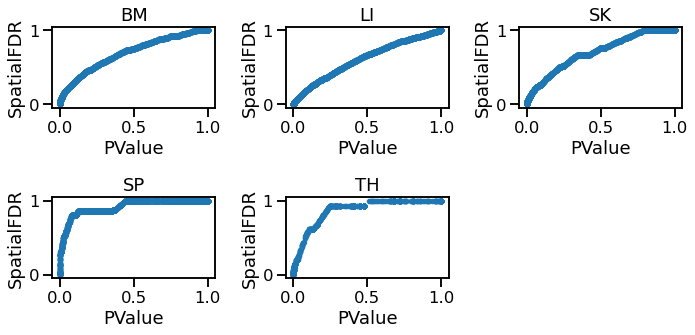

In [148]:
plt.rcParams["figure.figsize"] = [10,5]
i=1
for k in milo_res_2.keys():
    plt.subplot(2,3,i)
    plt.plot(milo_res_2[k].PValue, milo_res_2[k].SpatialFDR, '.');
    plt.title(k);
    plt.tight_layout();
    plt.xlabel("PValue");
    plt.ylabel("SpatialFDR");
    i+=1

In [149]:
## Exclude neighbourhoods where DA is explained by 10X protocol
# (eliminates false positives in the thymus, where there is partial
# confounding between method and age bins)
milo_res_method, org_fc_method, org_fdr_method = _milo_test_by_organ(adata, 
                                                      design="~ method",
                                                      test_organs = ["BM", "LI", "SK", "SP", "TH"]
                                                     )

org_fc_filtered_2 = org_fc_2.copy()
org_fdr_filtered_2 = org_fdr_2.copy()
for o in ["BM", "LI", "SK", "SP", "TH"]:
    org_fc_filtered_2["logFC_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan
    org_fdr_filtered_2["SpatialFDR_" + o][org_fdr_method["SpatialFDR_" + o] < 0.1] = np.nan


BM
LI
SK
SP
TH


### Visualize with beeswarm plot

In [150]:
## Read annotation groupings
import json
with open('../../metadata/anno_groups.json', 'r') as json_file:
    anno_groups_dict = json.load(json_file)

In [219]:
adata.uns["nhood_adata"].obs[adata.uns["nhood_adata"].obs["nhood_annotation"] == "MAST_CELL"]

index_cell  kth_distance  SpatialFDR  logFC_TH  \
29    FCAImmP7504909-ACTGAGTGTAGCTAAA      3.067364         NaN       NaN   
247   FCAImmP7528279-ATAGACCCAGCGTCCA      1.097889    0.903417  0.917206   
333   FCAImmP7579212-AGTGGGAAGTGAAGAG      2.532829         NaN       NaN   
334   FCAImmP7579212-GGGAGATTCAAACGGG      1.106570         NaN       NaN   
341   FCAImmP7579212-ACAGCTAAGATGTAAC      2.431335         NaN       NaN   
...                               ...           ...         ...       ...   
9239  FCAImmP7803021-TGCCCATTCGATGAGG      2.764824         NaN       NaN   
9334  FCAImmP7198628-ATAGACCGTTATGCGT      2.158510         NaN       NaN   
9392  FCAImmP7862089-ATAAGAGCATAAGACA      2.474090         NaN       NaN   
9498  FCAImmP7862089-CAGTAACCAAACCTAC      2.713902         NaN       NaN   
9615  FCAImmP7277565-GCTTGAACAGACGCAA      3.525782    0.290870  0.483344   

      SpatialFDR_TH  Nhood_size nhood_annotation  nhood_annotation_frac  \
29              NaN        40.0        MAST_CELL               0.975000   
247        0.056074        64.0        MAST_CELL               1.000000   
333             NaN        48.0        MAST_CELL               1.000000   
334             NaN        50.0        MAST_CELL               1.000000   
341             NaN        38.0        MAST_CELL               1.000000   
...             ...         ...              ...                    ...   
9239            NaN        40.0        MAST_CELL               0.850000   
9334            NaN        47.0        MAST_CELL               0.638298   
9392            NaN        29.0        MAST_CELL               1.000000   
9498            NaN        29.0        MAST_CELL               0.724138   
9615       0.620598        24.0        MAST_CELL               1.000000   

         logFC     logCPM         F    PValue       FDR  
29         NaN        NaN       NaN       NaN       NaN  
247  -0.218014  13.683950  0.048525  0.892217  0.905310  
333        NaN        NaN       NaN       NaN       NaN  
334        NaN        NaN       NaN       NaN       NaN  
341        NaN        NaN       NaN       NaN       NaN  
...        ...        ...       ...       ...       ...  
9239       NaN        NaN       NaN       NaN       NaN  
9334       NaN        NaN       NaN       NaN       NaN  
9392       NaN        NaN       NaN       NaN       NaN  
9498       NaN        NaN       NaN       NaN       NaN  
9615 -1.756113  13.567633  6.326633  0.207721  0.295475  

[162 rows x 13 columns]

In [151]:
org_fc_filtered = org_fc_filtered_2.copy()

## Add annotation
annotate_nhoods(adata, anno_col="anno_lvl_2_final_clean")
org_fc_filtered["nhood_anno"] = adata.uns["nhood_adata"].obs["nhood_annotation"]
org_fc_filtered.loc[adata.uns["nhood_adata"].obs["nhood_annotation_frac"] < 0.5, "nhood_anno"] = "Mixed"

anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}

org_fc_filtered['anno_group'] = [anno_groups_dict_rev[x] if x!="Mixed" else np.nan for x in org_fc_filtered['nhood_anno']]

In [ ]:
%%R -i org_fc_filtered -i org_fdr_2 -h 1000 -w 800

long_org_fc <- org_fc_filtered %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(nhood_anno, anno_group, Nhood), names_to="organ", values_to="logFC") %>%
    mutate(organ=str_remove(organ, "logFC_")) 

long_org_fdr <- org_fdr_2 %>%
    rowid_to_column("Nhood") %>%
    pivot_longer(cols= - c(Nhood), names_to="organ", values_to="SpatialFDR") %>%
    mutate(organ=str_remove(organ, "SpatialFDR_")) 
    
plot_df <- left_join(long_org_fc, long_org_fdr) %>%
    filter(!is.na(logFC)) %>%
    filter(nhood_anno!="nan") %>%
    filter(nhood_anno!="Mixed") %>%
    ## Fix organ naming and order 
    mutate(organ=factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ## Fix some names
    mutate(nhood_anno=ifelse(str_detect(nhood_anno, "NK$"), "NK", nhood_anno)) %>%
    ## Reorder by fold-change 
    group_by(organ, nhood_anno, Nhood) %>%
    mutate(mean_logFC = mean(logFC)) %>%
    ungroup() %>%
    group_by(organ, nhood_anno) %>%
    arrange(- mean_logFC) %>%
    ungroup()  %>%
    mutate(Nhood=factor(Nhood-1, levels=unique(Nhood-1))) %>% ## Back to zero indexing to match position in python obj
    group_by(nhood_anno) %>%
    filter(length(unique(Nhood)) > 20) %>%
    ungroup()

# plot_df %>%
#     filter(nhood_anno=='MAST_CELL') %>%
#     pull(Nhood) %>%
#     as.integer() %>%
#     sort()

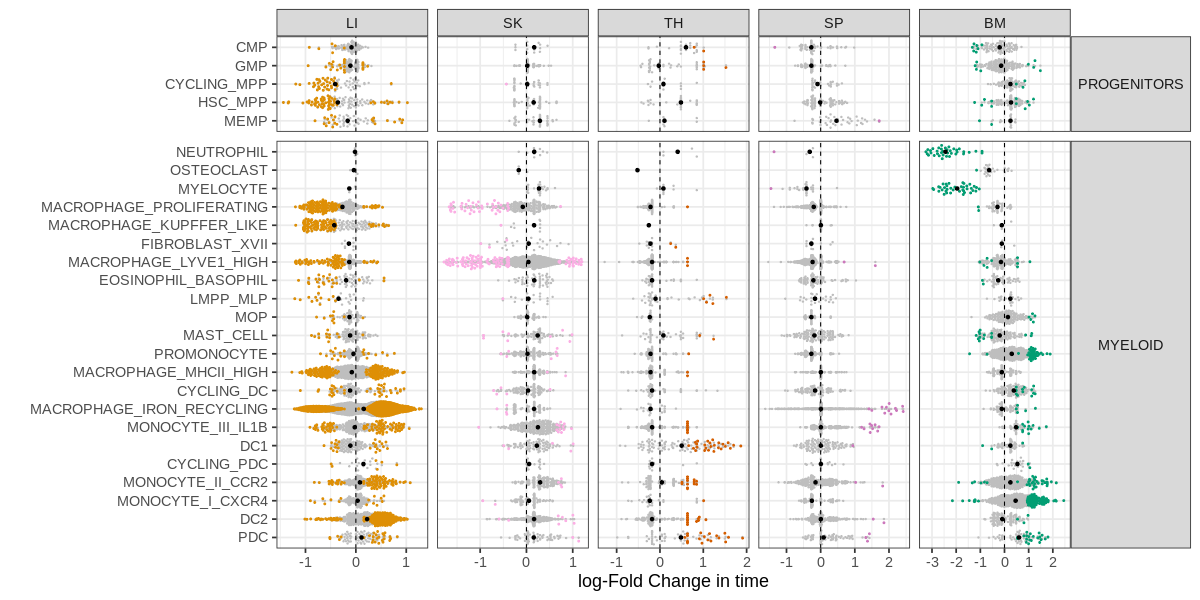

In [221]:
%%R -w 1200 -h 600 -i figdir -o pl_df
library(ggbeeswarm)
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

anno_group_order <- c("PROGENITORS", "ERYTHROID CELLS", "ILC", "MYELOID", "NK/T CELLS", "B CELLS")

pl_df <- plot_df %>%
    ## Reorder annotation names by median FC
    group_by(nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    arrange(- mean_logFC) %>%
    mutate(nhood_anno=factor(nhood_anno, levels=unique(nhood_anno))) %>%
    ## Calculate median per organ, to plot
    group_by(organ, nhood_anno) %>%
    mutate(mean_logFC = median(logFC)) %>%
    ungroup() %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "MYELOID"))

alpha=0.1
set.seed(12345)
pl1 <- pl_df %>%
    mutate(organ_color=ifelse(SpatialFDR < alpha, as.character(organ), NA)) %>%
    ggplot(aes(nhood_anno, logFC)) +
    geom_quasirandom(size=0.5, color="grey") +
    geom_quasirandom(data=. %>% filter(SpatialFDR < alpha), size=0.7, aes(color=organ_color)) +
    geom_point(data= . %>% distinct(organ, nhood_anno, anno_group, mean_logFC), aes(x=nhood_anno, y=mean_logFC), color="black")  +
    facet_grid(anno_group~organ, scales="free", space="free_y") +
    coord_flip() +
    scale_color_manual(values=organ_palette) +
    scale_fill_manual(values=organ_palette) +
    guides(color="none", fill="none") +
    geom_hline(yintercept=0, linetype=2) +
    theme_bw(base_size=18) +
    xlab("") + ylab("log-Fold Change in time") +
    scale_y_continuous(breaks=seq(-3,3, by=1)) +
    theme(strip.text.y=element_text(angle=0))
    
pl1 
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=15, height=15) +
#     ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=15, height=15)

Visualize distribution in age

In [70]:
# org_count_df = anno_obs.groupby(["organ", "anno_lvl_2_final_clean"]).count()['is_annotated'].reset_index()
# anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
# org_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in org_count_df.anno_lvl_2_final_clean]
# org_count_df.loc[org_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
# org_count_df["anno"] = org_count_df["anno_lvl_2_final_clean"]

In [160]:
org_colors = pd.read_csv("../../metadata/organ_colors.csv", index_col=0)

age_count_df = anno_obs.loc[adata.obs_names].groupby(["age", "anno_lvl_2_final_clean"]).count()['file'].reset_index()
anno_groups_dict_rev = {x:g for g,a in anno_groups_dict.items() for x in a}
age_count_df["anno_group"] = [anno_groups_dict_rev[x] if x in anno_groups_dict_rev.keys() else np.nan for x in age_count_df.anno_lvl_2_final_clean]
age_count_df.loc[age_count_df["anno_group"].isna(), "anno_group"] = "ERYTHROID CELLS"
age_count_df["anno"] = age_count_df["anno_lvl_2_final_clean"]

In [161]:
age_count_df

age anno_lvl_2_final_clean  file       anno_group          anno
0      4                  AS_DC     1          MYELOID         AS_DC
1      4                    CMP    13      PROGENITORS           CMP
2      4             CYCLING_DC   195          MYELOID    CYCLING_DC
3      4           CYCLING_MEMP    17      PROGENITORS  CYCLING_MEMP
4      4            CYCLING_MPP   103      PROGENITORS   CYCLING_MPP
..   ...                    ...   ...              ...           ...
392   17             OSTEOCLAST    72          MYELOID    OSTEOCLAST
393   17                    PDC   387          MYELOID           PDC
394   17                PRE_DC2    32          MYELOID       PRE_DC2
395   17            PROMONOCYTE  1295          MYELOID   PROMONOCYTE
396   17           PROMYELOCYTE   172  ERYTHROID CELLS  PROMYELOCYTE

[397 rows x 5 columns]

In [162]:
%%R -i age_count_df --i figdir -w 800 -h 1000
anno_order <- unique(as.character(pl1$data$nhood_anno))

age_pl_df <- age_count_df %>%
    rename(N_cells = file) %>%
    group_by(anno) %>%
    mutate(anno=factor(anno, levels=anno_order)) %>%
    filter(!is.na(anno)) %>%
    mutate(anno_group=factor(anno_group, levels=anno_group_order)) %>%
    filter(!is.na(anno_group)) %>%
    filter(anno_group %in% c("PROGENITORS", "MYELOID"))
   
    
pl2 <- age_pl_df %>%
    mutate(grid='') %>%
    ggplot(aes(anno, N_cells)) + 
    geom_col(aes(fill=age),position="fill", width=0.8) +
    coord_flip() +
    facet_grid(anno_group~grid, space="free", scales="free") +
    scale_fill_viridis_c() +
    theme_bw(base_size=18) +
    theme(strip.text.y=element_text(angle=0)) +
    ylab("fraction of cells") + xlab("") +
    expand_limits(y = 1.3) +
    geom_text(data=. %>% group_by(anno) %>% 
              summarise(N_cells=sum(N_cells), anno_group=first(anno_group)),
              hjust=0,
              y=1.01, aes(label=paste("N =", N_cells))
             ) 
#     ggsave(paste0(figdir, "age_distribution.pdf"), height=16, width=12) +
#     ggsave(paste0(figdir, "age_distribution.png"), height=16, width=12) 

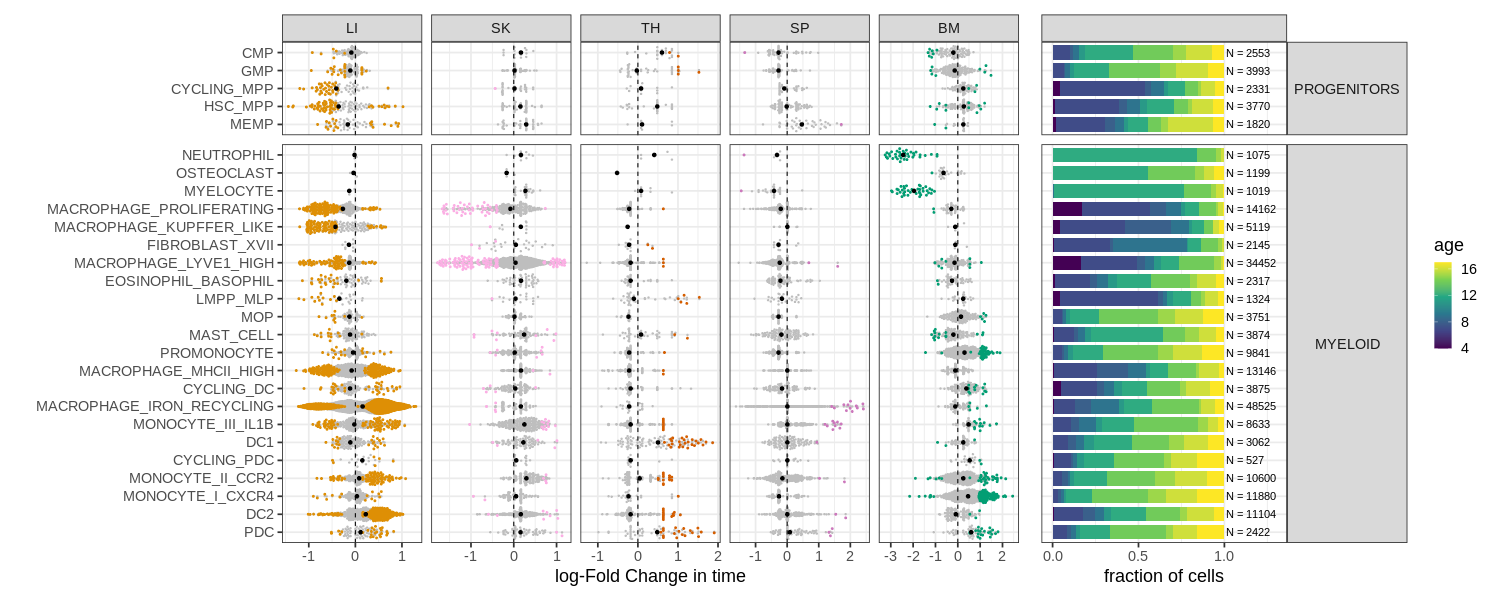

In [163]:
%%R -w 1500 -h 600
(pl1 + theme(strip.background.y=element_blank(), strip.text.y=element_blank())) +
(pl2 + remove_y_axis()) +
plot_layout(widths=c(3,1)) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=25, height=10) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=25, height=10)

In [164]:
org_age_range  = anno_obs.loc[adata.obs_names][['organ', "age"]].drop_duplicates()

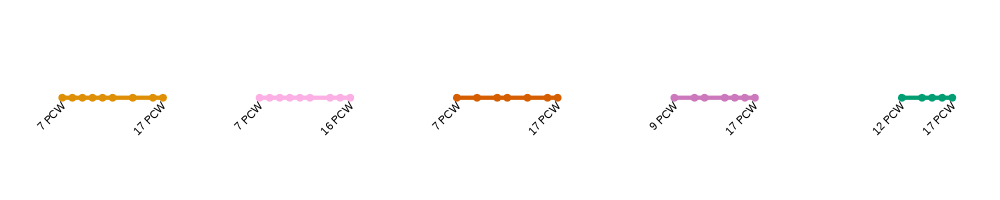

In [165]:
%%R -i org_age_range -w 1000 -h 200
organ_ord <- c("LI", "SK", "TH", "SP", "BM")
p3 <- org_age_range %>%
    filter(organ %in% organ_ord) %>%
    mutate(organ=factor(organ, levels=organ_ord)) %>%
    group_by(organ) %>%
    mutate(max_age=paste0(max(age), " PCW"), 
           min_age=paste0(min(age), " PCW")) %>%
    mutate(y=1) %>%
    ggplot(aes( age, y, color=organ)) +
    geom_point(size=3) +
    geom_line(size=2) +
    geom_text(data=. %>% group_by(organ) %>% filter(age==min(age)), 
              aes(label=min_age), angle=45,
              vjust = 1.2, 
              hjust = 1.1, nudge_x = -0.05, color='black') +
    geom_text(data=. %>% group_by(organ) %>% filter(age==max(age)), 
              aes(label=max_age), angle=45,
              vjust = 1.2,  
              hjust = 1.1, nudge_x = -0.05, color='black') +
    facet_grid(.~organ) +
    scale_color_manual(values=organ_palette) +
    theme_classic(base_size=18) +
     expand_limits(x = c(3,20)) +
    remove_y_axis() + remove_x_axis() + 
    guides(color='none') +
    xlab("") + ylab("log-Fold Change in time") +
    theme(strip.text.y=element_text(angle=0), axis.line=element_blank(), 
          strip.background=element_blank(), strip.text=element_blank())
p3

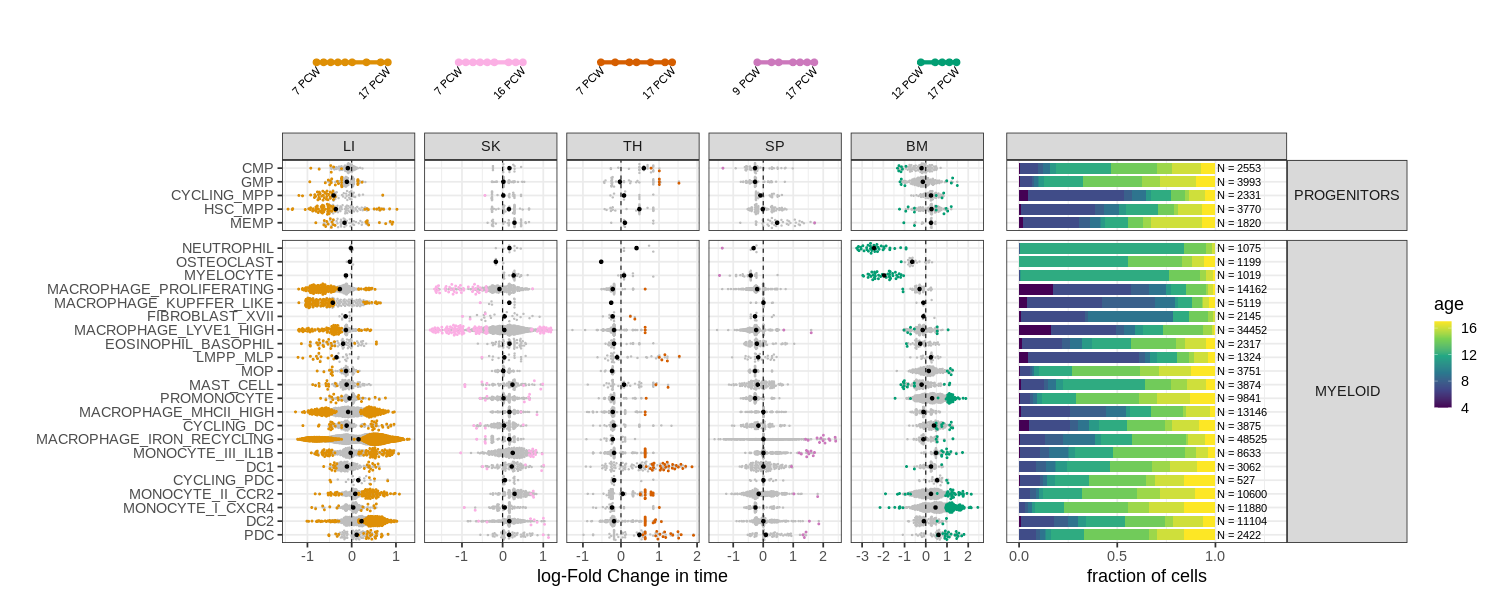

In [166]:
%%R -w 1500 -h 600
layout <- "
AAAAA##
BBBBBCC
BBBBBCC
BBBBBCC
BBBBBCC
"

(p3 + 
 (pl1 + theme(strip.background.y=element_blank(), strip.text.y=element_blank())) + 
 (pl2 + remove_y_axis())) +
plot_layout(design=layout) +
# ((p3 / (pl1 + theme(strip.background.y=element_blank(), strip.text.y=element_blank())) +
#      plot_layout(heights=c(1,10)) 
#  ) |
# (plot_spacer() / pl2 + remove_y_axis()) + plot_layout(heights=c(1,10)) ) +
# plot_layout(widths=c(3,1)) 
ggsave(paste0(figdir, "milo_results_overview_beeswarm.pdf"), width=25, height=10) +
ggsave(paste0(figdir, "milo_results_overview_beeswarm.png"), width=25, height=10)

In [223]:
pl_df['nhood_anno'] == 'MAST_CELL' 

1        False
2        False
3        False
4        False
5        False
         ...  
17169    False
17170    False
17171    False
17172    False
17173    False
Name: nhood_anno, Length: 17173, dtype: bool

In [273]:
pl_df

Nhood  nhood_anno anno_group organ     logFC    SpatialFDR  mean_logFC
1      9694         PDC    MYELOID    TH  1.905909  2.947499e-08    0.483344
2      9716         PDC    MYELOID    BM  1.798771  1.903415e-05    0.601498
3      9645         PDC    MYELOID    BM  1.688260  2.288357e-04    0.601498
4      9693         PDC    MYELOID    TH  1.581703  1.256531e-07    0.483344
5      9637         PDC    MYELOID    BM  1.558793  4.836345e-04    0.601498
...     ...         ...        ...   ...       ...           ...         ...
17169  7051  NEUTROPHIL    MYELOID    BM -3.063589  2.671296e-08   -2.443739
17170  7025  NEUTROPHIL    MYELOID    BM -3.145879  2.619696e-09   -2.443739
17171  4094  NEUTROPHIL    MYELOID    BM -3.172958  2.619696e-09   -2.443739
17172  4093  NEUTROPHIL    MYELOID    BM -3.198502  2.619696e-09   -2.443739
17173  9227  NEUTROPHIL    MYELOID    BM -3.251817  2.619696e-09   -2.443739

[17173 rows x 7 columns]

### Visualize on UMAP

In [79]:
milopy.utils.build_nhood_graph(adata)

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


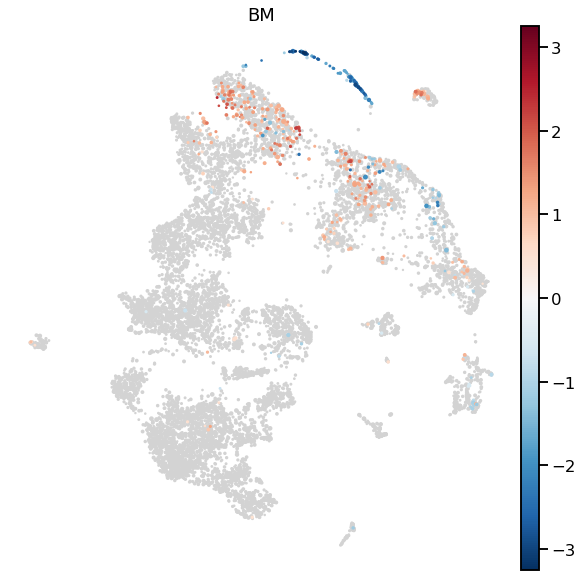

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


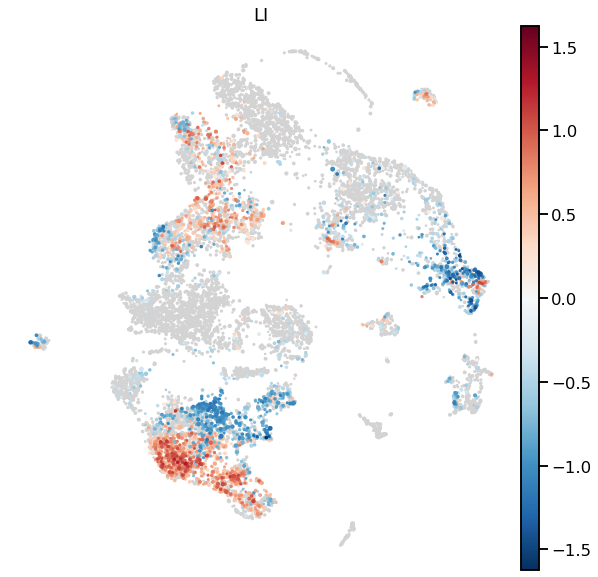

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


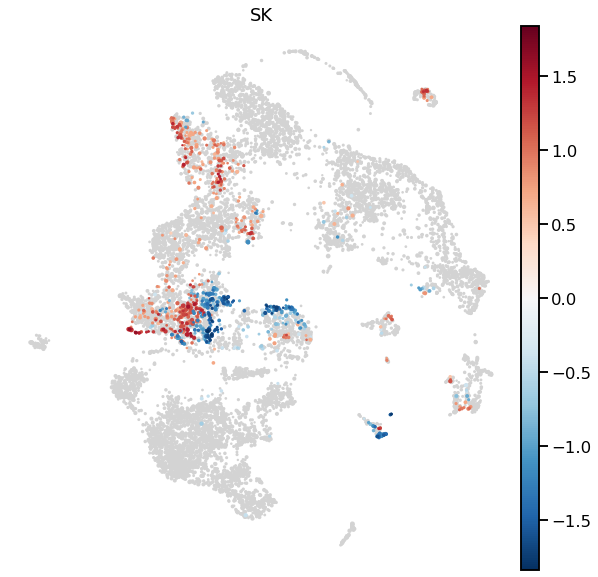

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


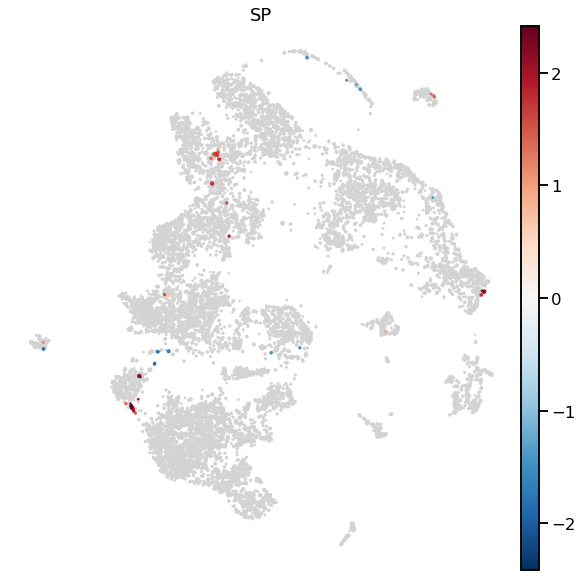

Trying to set attribute `.obs` of view, copying.
... storing 'nhood_annotation' as categorical


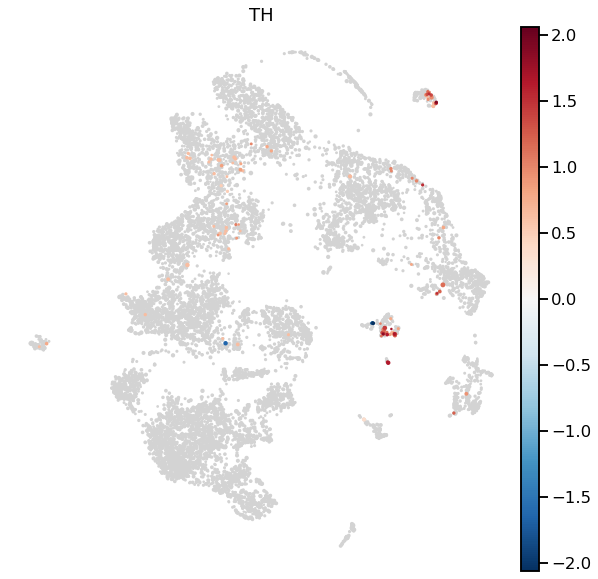

In [80]:
test_organs = ["BM", "LI", "SK", "SP", "TH"]
plt.rcParams['figure.figsize'] = [10,10]
for i in range(len(test_organs)):
    adata.uns["nhood_adata"].obs = milo_res_2[test_organs[i]].copy()
    adata.uns["nhood_adata"].obs["Nhood_size"] = np.array(adata.obsm["nhoods"].sum(0)).flatten()
    milopy.plot.plot_nhood_graph(adata, min_size=1, title=test_organs[i], save="milo_nhoods_graph_{o}.png".format(o=test_organs[i]),
                )


### Save processed outputs

In [96]:
outdir = '/nfs/team205/ed6/data/Fetal_immune/milo_outs/{s}/'.format(s=split)

if not os.path.exists(outdir):
    os.mkdir(outdir)

In [231]:
## Save dataframe for beeswarm plot
pl_df.to_csv(outdir + "milo_beeswarm_plot_data.{s}.csv".format(s=split))

In [83]:
## Save processed anndata object
nhood_adata = adata.uns["nhood_adata"].copy()
# adata.obs.drop("remarks", axis=1, inplace=True)
del adata.uns["nhood_adata"]
adata.write_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))
adata.uns["nhood_adata"] = nhood_adata.copy()

nhood_adata.uns["annotation_labels"] = nhood_adata.uns["annotation_labels"].tolist()
nhood_adata.write_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))

... storing 'nhood_annotation' as categorical


In [97]:
## Read processed outputs
nhood_adata = sc.read_h5ad(outdir + "milo_nhood_adata.{s}.h5ad".format(s=split))
pl_df = pd.read_csv(outdir + "milo_beeswarm_plot_data.{s}.csv".format(s=split))

adata = sc.read_h5ad(outdir + "adata4milo.{s}.h5ad".format(s=split))


In [98]:
adata.uns["nhood_adata"] = nhood_adata.copy()

In [99]:
cut_labels_4 = ['< 8pcw', '< 10pcw', '< 12pcw', '< 14pcw', '< 16pcw', '< 18pcw']

### Differential expression analysis

Calculate mean expression for each neighbourhood

In [100]:
## Add mean expression for each neighbourhood
nhood_adata = adata.uns["nhood_adata"].copy()
X = adata.X
expr_id = "expr" 
## Aggregate over nhoods -- taking the mean
nhoods_X = X.T.dot(adata.obsm["nhoods"])

from scipy.sparse import csr_matrix
nhoods_X = csr_matrix(nhoods_X / adata.obsm["nhoods"].toarray().sum(0))
adata.uns["nhood_adata"].obsm[expr_id] = nhoods_X.T

Label neighbourhoods by outcome in each organ test

In [232]:
long_org_fc = pl_df.copy()
alpha=0.1

In [235]:
signif_early = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] < 0)
signif_late = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] > 0)
not_signif = (long_org_fc['SpatialFDR'] >= alpha)

long_org_fc['test_label'] = "not_signif"
long_org_fc.loc[signif_late, "test_label"] = "signif_late"
long_org_fc.loc[signif_early, "test_label"] = "signif_early"

In [236]:
def test_DGE(adata, long_org_fc, subset_organ, subset_anno, alpha=0.1, 
             condition='signif_late', test_type='vs_rest',
                max_frac = 0.8
            ):
    '''
    Extract cells in neighbourhoods with significant enrichment in early or late cells and use 
    simple scanpy test to find markers VS the rest of cells in the same organ/annotation.
    
    Params:
    -------
    - long_org_fc: long format dataframe containing milo testing results
    - subset_organ: list of organs to test in
    - subset_anno: list or cell types to test in (values or `anno_lvl_2_final_clean`)
    - alpha: significance FDR threshold (default=0.1)
    - condition: which condition to compare to the rest? (either `signif_late` or `signif_early`)
    - test_type: 'vs_rest' condition VS all other cells, 'vs_opposite' condition VS opposite condition
    - max_frac: exclude genes that are expressed in more than this fraction of cells in all age bins 
    (to exclude very highly expressed genes in all the cluster)
    '''
    keep_nhoods_df = long_org_fc[(long_org_fc.organ.isin(subset_organ)) & (long_org_fc.nhood_anno.isin(subset_anno))][["Nhood", "test_label"]]
    pick_nhoods = keep_nhoods_df[keep_nhoods_df['test_label'] == condition]["Nhood"].astype('int')

    cells_in_nhoods = adata.obsm["nhoods"][:,pick_nhoods].toarray().sum(1) > 0
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))

    test_adata = adata[cells_in_org]
    
    ## Define case VS control
    case_cells = adata[cells_in_org & cells_in_nhoods].obs_names
    if test_type == "vs_rest":
        test_adata.obs["test_condition"] = 'control'
        test_adata.obs.loc[case_cells, "test_condition"] = 'case'
    elif test_type == 'vs_opposite':
        test_adata.obs["test_condition"] = np.nan
        all_conditions = ['signif_early', 'signif_late']
        opposite_condition = [x for x in all_conditions if x != condition][0]
        opposite_pick_nhoods = keep_nhoods_df[keep_nhoods_df['test_label'] == opposite_condition]["Nhood"].astype('int')
        opposite_cells_in_nhoods = adata.obsm["nhoods"][:,opposite_pick_nhoods].toarray().sum(1) > 0
        opposite_case_cells = adata[cells_in_org & opposite_cells_in_nhoods].obs_names
        test_adata.obs.loc[opposite_case_cells, "test_condition"] = 'control'
        test_adata.obs.loc[case_cells, "test_condition"] = 'case'
        
    ## Filter genes that are highly expressed everywhere
    high_x = np.empty(shape=(test_adata.n_vars,1))
    for b in test_adata.obs['age_bins'].unique():
        X_bin = test_adata[test_adata.obs['age_bins']==b].X
        nonz_X_bin = X_bin != 0
        top_n_cells = np.round(nonz_X_bin.shape[0]*max_frac)
        high_x_b = np.array(nonz_X_bin.sum(0)).ravel() >= top_n_cells
        high_x = np.hstack([high_x, high_x_b.reshape((test_adata.n_vars,1))])

    high_x =high_x[:,1:]
    keep_vars = test_adata.var_names[np.where(high_x.sum(1) < high_x.shape[1])[0]]
    test_adata = test_adata[:,test_adata.var_names.isin(keep_vars)]

#     if len(case_cells) < 10:
    sc.tl.rank_genes_groups(test_adata, groupby="test_condition", groups=["case"], reference="control")
    
    ## Get dataframe of results
    dge_dict = test_adata.uns['rank_genes_groups'].copy()
    dge_dict.pop("params")
    dge_dict = {k:[x[0] for x in dge_dict[k]] for k,v in dge_dict.items()}
    dge_df = pd.DataFrame.from_dict(dge_dict)
    
    return(test_adata, dge_df)

def get_top_DEGs(dge_df, FC_direction = None, n_genes=30, min_fc=None, alpha=0.01):
    ## Extract top genes and order by FC
    dge_df = dge_df[dge_df['pvals_adj'] < alpha]
    dge_df['abs_logfoldchanges'] = np.abs(dge_df['logfoldchanges'])
    genes_df = dge_df.sort_values("abs_logfoldchanges", ascending=False)
#     genes_df = dge_df.sort_values("pvals_adj")
    if min_fc is not None:
        genes_df = genes_df[np.abs(genes_df.logfoldchanges) > min_fc]
    if FC_direction is not None:
        genes_df = genes_df[np.sign(genes_df.logfoldchanges) == FC_direction]
    genes = genes_df.iloc[0:n_genes].sort_values("logfoldchanges", ascending=False).names.values
    return(genes)

def plot_DGE(test_adata, dge_df, subset_organ, subset_anno, FC_direction = None,  min_fc=0.1, n_genes=30, figsize=[4,10], save=False, **kwargs):
    ## Extract top genes and order by FC
    genes = get_top_DEGs(dge_df, FC_direction = FC_direction, n_genes=n_genes,  min_fc=None)
  
    #     genes_dict = {}
    #     genes_dict["down"] = genes_df[genes_df["logfoldchanges"] < 0]['names'].values
    #     genes_dict["up"] = genes_df[genes_df["logfoldchanges"] > 0]['names'].values
    
    test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
    pl_title = ''.join(subset_anno) + " - " + ''.join(subset_organ) 
    ax = sc.pl.dotplot(test_adata, genes, groupby='age_bins', dendrogram=False, cmap="Reds", 
#                          standard_scale="var",
                         return_fig=False, title=pl_title, swap_axes=True, show=False, 
                               figsize=figsize , **kwargs
                        );
    fig = plt.gcf()
    plot_ax = fig.axes[1]
    cbar_ax = fig.axes[-1]
    cbar_ax.set_title("Median\nexpression");
    bins_labels = dict(zip([str(x) for x in range(len(cut_labels_4))], cut_labels_4))
    plot_ax.set_xticklabels([bins_labels[x.get_text()] for x in plot_ax.get_xticklabels()], 
                            rotation=45, ha="right");
    if save:
        fig.savefig(figdir + pl_title + '_stacked_violin.png', bbox_inches="tight")

In [237]:
def anndata2pseudobulk(adata, group_by, agg="s", min_ncells = 10):
    '''
    Params:
    ------
    adata: the anndata object
    group_by: list of obs columns to use for aggregation
    agg: "s" for sum (if adata.X are counts), "m" for mean (if adata.X are log-counts), 'n' for n expressing
    min_ncells: minimum number of cells to keep pseudobulk sample (default=10)
    '''
    from scipy.sparse import csr_matrix
    import anndata
    if agg=="s" and "log1p" in adata.uns_keys():
        print("adata.X is in log-transformed, pseudobulking should be done on counts")
        return()
    ## Make obs for pseudobulk
    pseudobulk_obs = adata.obs[group_by].drop_duplicates()
    pseudobulk_obs = pseudobulk_obs[group_by].astype("str")
    pseudobulk_obs.index = pseudobulk_obs[group_by].agg("-".join, axis=1)
    ## Add column to obs assigning cells to pseudobulk samples
    adata.obs[group_by] = adata.obs[group_by].astype("str")
    adata.obs["pseudobulk_sample"] = adata.obs[group_by].agg("-".join, axis=1)
    ## Sum counts from same sample
    sample_dummies = pd.get_dummies(adata.obs["pseudobulk_sample"])[pseudobulk_obs.index].values
    sample_dummies = scipy.sparse.csr_matrix(sample_dummies)
    pseudobulk_X = adata.X.T.dot(sample_dummies)
    ## Check that pseudobulk profiles are the sum of all profiles in a sample
    a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
    b = pseudobulk_X[:,0].toarray().flatten()
    if not np.all(a == b):
        print("Error! Aggregation doesn't coincide with sum across the same sample")
        return()
    if agg=="m":
        pseudobulk_X = csr_matrix(pseudobulk_X / sample_dummies.toarray().sum(0))
    if agg=='n':
        adata.X[adata.X != 0] = 1
        pseudobulk_X = adata.X.T.dot(sample_dummies)
        ## Check that pseudobulk profiles are the sum of all profiles in a sample
        a = np.array(adata[sample_dummies[:,0]!=0].X.sum(0)).flatten()
        b = pseudobulk_X[:,0].toarray().flatten()
    ## Make new anndata object
    pseudobulk_adata = anndata.AnnData(pseudobulk_X.T, obs=pseudobulk_obs, var=adata.var)
    ## Add number of cells to obs 
    n_cells = adata.obs.groupby('pseudobulk_sample').count().iloc[:,0]
    n_cells.name = "n_cells"
    pseudobulk_adata.obs = pd.concat([pseudobulk_adata.obs, n_cells], axis=1)
    ## Filter obs by number of cells threshold
    pseudobulk_adata = pseudobulk_adata[pseudobulk_adata.obs['n_cells'] >= min_ncells]
    return(pseudobulk_adata)

In [20]:
%%R -i cut_labels_4 
## Plotting function
plot_time_highlight <- function(X_pl_df, N_pl_df, genes, highlight_genes, mean_gex_limits=c(0,6)){

    pl_df <- left_join(
        X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
        N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
        ) %>%
        mutate(gene=factor(gene, levels=rev(genes))) %>%
        group_by(gene, organ) %>%
        mutate(mean_gex=scale(mean_gex, scale=FALSE, center=TRUE)) %>%
        mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
        mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
        mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) 

    highlight_df <- data.frame(gene=genes, organ='') %>%
        mutate(highlight=ifelse(gene %in% highlight_genes, gene, NA))

    highlight_pl <- pl_df %>%
        full_join(highlight_df) %>%
        mutate(gene=factor(gene, levels=levels(pl_df$gene))) %>%
        ggplot(aes(1, gene)) +
        ggrepel::geom_text_repel(data=. %>% filter(organ==""), aes(label=highlight),
                                 size=5,
                                  xlim = c(0.7,0.9), direction = "y", hjust = "left",
                                min.segment.length=0) +
        scale_x_continuous(expand=expansion(mult = c(0.3,0))) +
        cowplot::theme_nothing() +
                theme(plot.margin=margin(0, 0, 0, 0, "cm"))
    pl1 <- pl_df %>%
       ggplot(aes( age_bins, gene)) +
        geom_tile(aes(fill=mean_gex)) +
        facet_grid(.~organ, space="free", scales="free") +
#         scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression', limits=mean_gex_limits) +
        scale_fill_distiller(palette='RdBu', name='Mean expression', limits=mean_gex_limits) +
        guides(fill=guide_colorbar()) +
        ylab("DEGs") + xlab("Age bins") +
        theme_classic(base_size=16) +
        remove_y_axis() +
        theme(axis.text.x=element_text(angle=45, hjust=1), 
              axis.text.y=element_blank(), axis.ticks.y=element_blank(),
#               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
             )
    (highlight_pl | pl1) +
        plot_layout(widths=c(1,3)) 
}

#### Early Macs

skin and liver Mac_I and Mac_III

In [161]:
## Provided by Laura
mac_functional_genes = {
    'iron_recycling':{
        'SLC40A1', "SLC48A1", 'TIMD4', "CD163","LRP1", "FTH1", "HMOX1",
        "BLVRA", "BLVRB", "SLC11A1", "SLC11A2", "SPIC", "VCAM1", "CSF1R",
        "PCBP2"
    },
    'LYVEhi_macs':{
        'LYVE1', "F13A1", "SPP1", "CCL4", "MRC1", "STAB1", "LIPA"
    },
    'class_II':{
        'HLA-DPA1',"HLA-DRA", "HLA-DMA", "HLA-DQB1", "CLEC7A", "AOAH"
    },
    'proliferating':['MKI67', 'TOP2A']
}


In [151]:
mac3_adata = adata[adata.obs['anno_lvl_2_final_clean'].str.startswith("MACROPHAGE_III")].copy()

mac3_adata.obs['age_bins'] = mac3_adata.obs['age_bins'].astype("category")

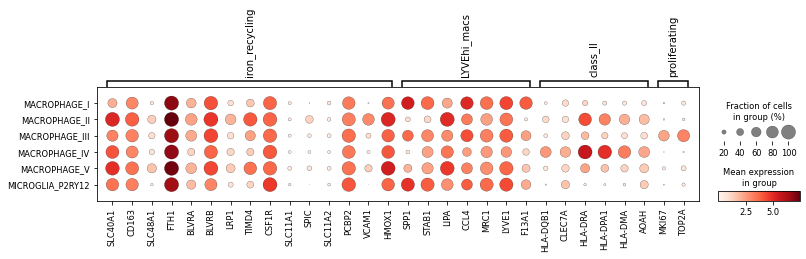

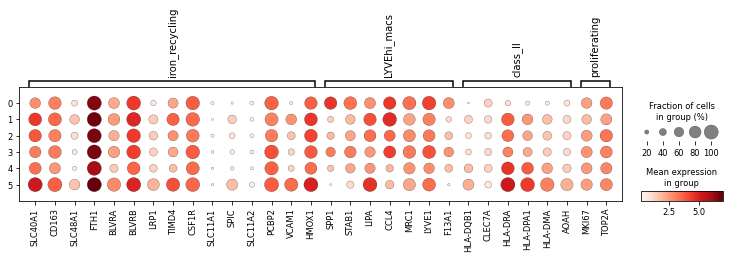

In [171]:
sc.pl.dotplot(adata[(adata.obs['anno_lvl_2_final_clean'].str.startswith("MAC")) | (adata.obs['anno_lvl_2_final_clean'] == 'MICROGLIA_P2RY12')], mac_functional_genes, groupby='anno_lvl_2_final_clean')
sc.pl.dotplot(mac3_adata, mac_functional_genes, groupby='age_bins', swap_axes=False)

In [400]:
query_sets = [
    [["MACROPHAGE_I"],["SK", 'LI'], "signif_early"],
    [["MACROPHAGE_III"],["SK", 'LI'], "signif_early"]
]

In [401]:
# adata.layers['logcounts'] = adata.X.copy()
# sc.pp.scale(adata)

# adata.X = adata.layers['logcounts'].copy()

#### MacIII

In [402]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in ["SK", 'LI', "YS"]:
    cells_in_org = (adata.obs.organ.isin(["SK", 'LI', "YS"])) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["SK", 'LI', "YS"]:
    cells_in_org = (adata.obs.organ.isin(["SK", 'LI', "YS"])) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [403]:
## Save DEG table
df = pd.DataFrame(ordered_genes, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [414]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes
inflam_genes <- c("TNF", "CXCR4", "IL1B", "CCL4L2", "CXCL8", "ILRL2", "CCL4", "CCL3", 'CCL3L1')
gex_lims <- c(-3,3)

p2_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes, mean_gex_limits=gex_lims)
p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, inflam_genes, mean_gex_limits=gex_lims)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


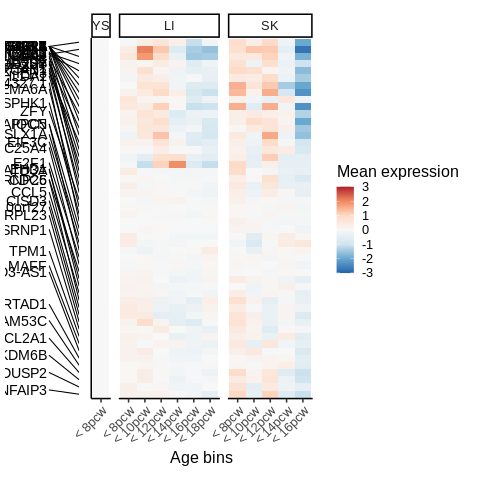

In [415]:
%%R
p2_all

Plot functional genes

In [416]:
## mean expression
genes = ['MKI67', "TOP2A"]
X_df_ls = []
for org in ["SK", 'LI', "YS"]:
    cells_in_org = (adata.obs.organ.isin(["SK", 'LI', "YS"])) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["SK", 'LI', "YS"]:
    cells_in_org = (adata.obs.organ.isin(["SK", 'LI', "YS"])) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [417]:
%%R -i figdir -i X_pl_df -i N_pl_df -i genes
p2_func <- plot_time_highlight(X_pl_df, N_pl_df, genes, genes, mean_gex_limits=gex_lims)
# p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, inflam_genes, mean_gex_limits=c(0,7))

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


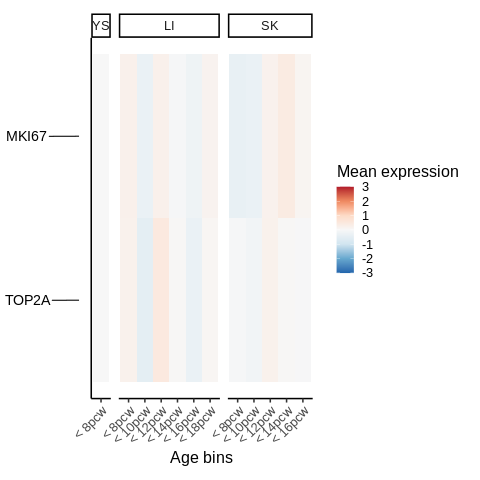

In [418]:
%%R
p2_func

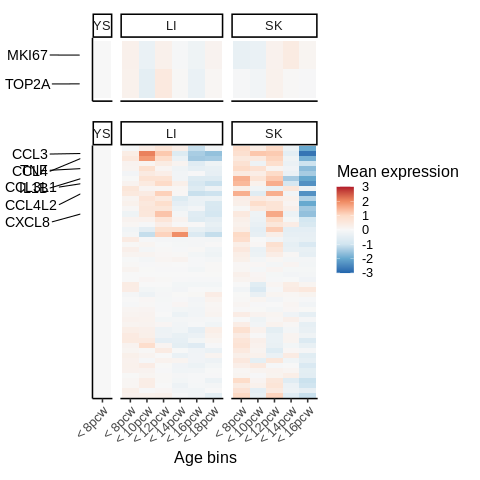

In [419]:
%%R
((p2_func + remove_x_axis()) / (p2_highlight) ) +
plot_layout(guides='collect', heights=c(1,4)) +
    ggsave(paste0(figdir,"MAC_III_DE.png"), width=8, height=8) + 
    ggsave(paste0(figdir,"MAC_III_DE.pdf"), width=8, height=8)

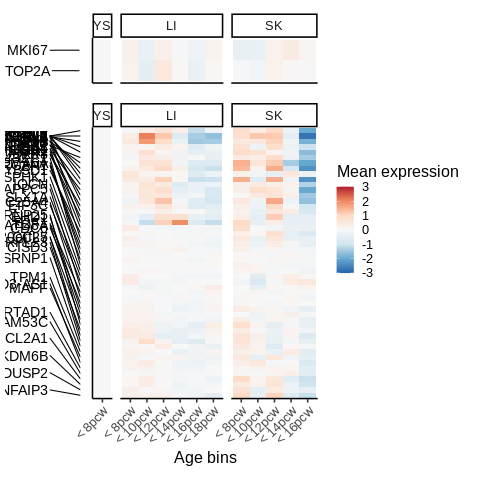

In [420]:
%%R
((p2_func + remove_x_axis()) / (p2_all) ) +
plot_layout(guides='collect', heights=c(1,6)) +
ggsave(paste0(figdir,"MAC_III_DE_full.png"), width=10, height=16) + 
    ggsave(paste0(figdir,"MAC_III_DE_full.pdf"), width=10, height=16)

#### MacI

In [421]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical


In [452]:
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in ["SK", 'LI', "YS"]:
    cells_in_org = (adata.obs.organ.isin(["SK", 'LI', "YS"])) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["SK", 'LI', "YS"]:
    cells_in_org = (adata.obs.organ.isin(["SK", 'LI', "YS"])) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [453]:
## Save DEG table
df = pd.DataFrame(ordered_genes, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [456]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes
inflam_genes <- c("TNF", "CXCR4", "IL1B", "CCL4L2", "CXCL8", "ILRL2", "CCL4", "CCL3", 'CCL3L1', 'LYVE1')
gex_lims <- c(-3, 3)
p2_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes, mean_gex_limits=gex_lims)
p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, inflam_genes, mean_gex_limits=gex_lims)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


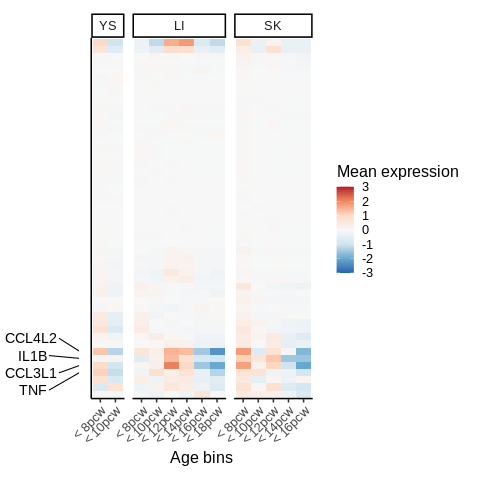

In [457]:
%%R
p2_highlight

Plot functional genes

In [458]:
## mean expression
genes = list(mac_functional_genes['LYVEhi_macs'])
X_df_ls = []
for org in ["SK", 'LI', "YS"]:
    cells_in_org = (adata.obs.organ.isin(["SK", 'LI', "YS"])) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["SK", 'LI', "YS"]:
    cells_in_org = (adata.obs.organ.isin(["SK", 'LI', "YS"])) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [459]:
%%R -i figdir -i X_pl_df -i N_pl_df -i genes
p2_func <- plot_time_highlight(X_pl_df, N_pl_df, genes, genes, mean_gex_limits=gex_lims)
# p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, inflam_genes, mean_gex_limits=c(0,7))

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


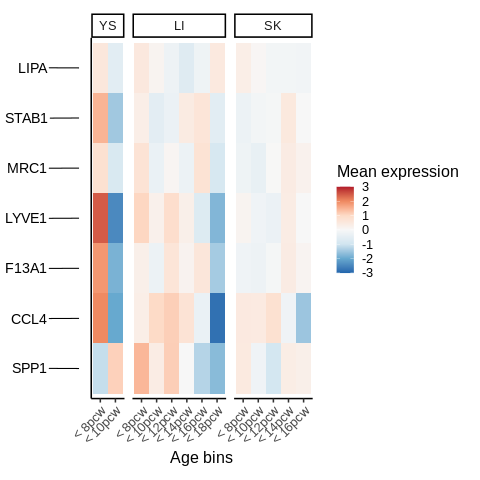

In [460]:
%%R
p2_func

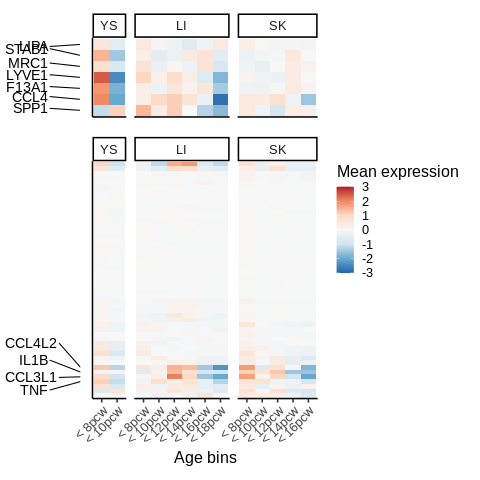

In [461]:
%%R
((p2_func + remove_x_axis()) / (p2_highlight) ) +
plot_layout(guides='collect', heights=c(1,3)) +
ggsave(paste0(figdir,"MAC_I_DE.png"), width=8, height=8) + 
    ggsave(paste0(figdir,"MAC_I_DE.pdf"), width=8, height=8)

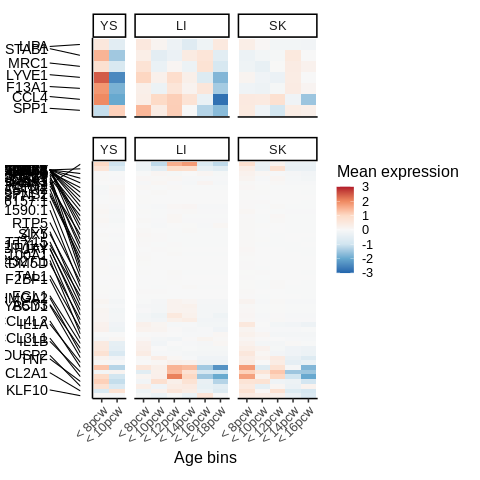

In [462]:
%%R
((p2_func + remove_x_axis()) / (p2_all) ) +
plot_layout(guides='collect', heights=c(1,3)) +
ggsave(paste0(figdir,"MAC_I_DE_full.png"), width=10, height=18) + 
    ggsave(paste0(figdir,"MAC_I_DE_full.pdf"), width=10, height=18)

#### MacII

In [463]:
query_sets = [
    [["MACROPHAGE_II"],["SP", "LI"], "signif_late"], 
]

In [464]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [465]:
## Save DEG table
df = pd.DataFrame(ordered_genes, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [472]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes
antigen_pres_genes <- c("HLA-DRA", "HLA-DRB5","HLA-DPB1","IL18",  "VEGFA", "CXCR4", "CLEC10A")
gex_lims <- c(-2.7,2.7)
p2_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes, mean_gex_limits=gex_lims)
p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, antigen_pres_genes, mean_gex_limits=gex_lims)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


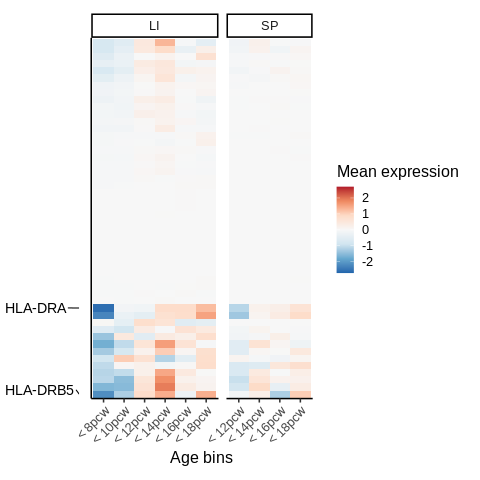

In [473]:
%%R
p2_highlight

Plot functional genes

In [474]:
## mean expression
genes = list(mac_functional_genes['iron_recycling'])
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [475]:
%%R -i figdir -i X_pl_df -i N_pl_df -i genes
p2_func <- plot_time_highlight(X_pl_df, N_pl_df, genes, genes, mean_gex_limits=gex_lims)
# p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, inflam_genes, mean_gex_limits=c(0,7))

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


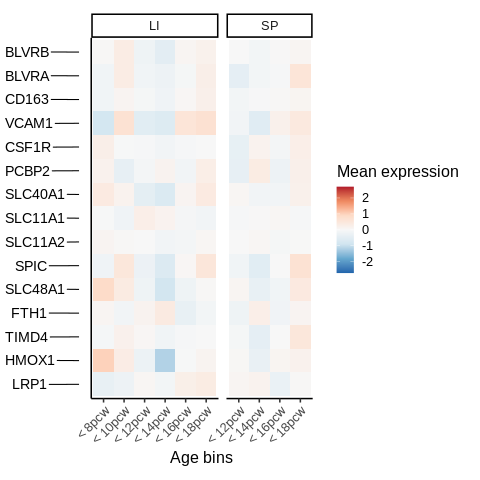

In [476]:
%%R
p2_func

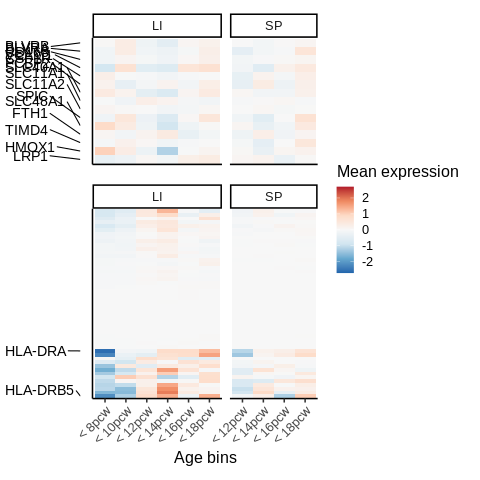

In [477]:
%%R
((p2_func + remove_x_axis()) / (p2_highlight) ) +
plot_layout(guides='collect', heights=c(1,1.5)) +
ggsave(paste0(figdir,"MAC_II_DE.png"), width=8, height=11) + 
    ggsave(paste0(figdir,"MAC_II_DE.pdf"), width=8, height=11)

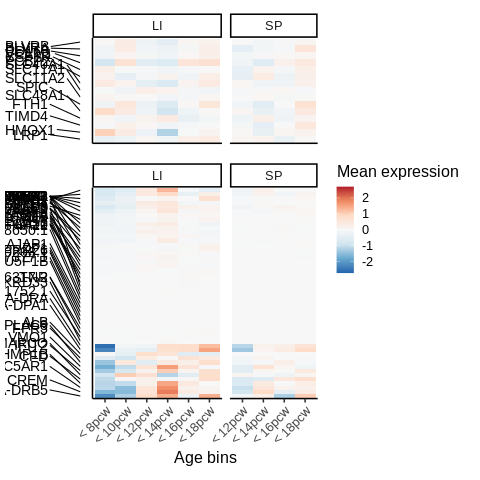

In [479]:
%%R
((p2_func + remove_x_axis()) / (p2_all) ) +
plot_layout(guides='collect', heights=c(1,2)) +
ggsave(paste0(figdir,"MAC_II_DE_full.png"), width=11, height=19) + 
    ggsave(paste0(figdir,"MAC_II_DE_full.pdf"), width=11, height=19)

#### MacIV

In [480]:
query_sets = [
    [["MACROPHAGE_IV"],["SP", "LI"], "signif_late"], 
]

In [481]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [482]:
## Save DEG table
df = pd.DataFrame(ordered_genes, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [483]:
hla_genes = list(mac_functional_genes['class_II'])

In [486]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes -i hla_genes
high_genes <- c(  "VEGFA", "CXCR4", "CLEC10A", hla_genes)
gex_lims=c(-2.5,2.5)
p2_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes, mean_gex_limits=gex_lims)
p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, antigen_pres_genes, mean_gex_limits=gex_lims)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


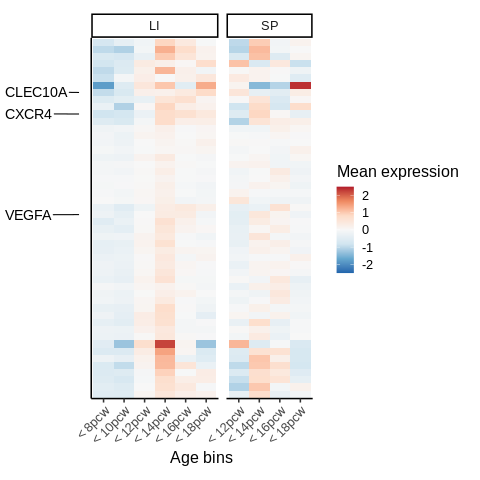

In [487]:
%%R
p2_highlight

Plot functional genes

In [489]:
## mean expression
genes = list(mac_functional_genes['class_II'])
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [492]:
%%R -i figdir -i X_pl_df -i N_pl_df -i genes
p2_func <- plot_time_highlight(X_pl_df, N_pl_df, genes, genes, mean_gex_limits=gex_lims)
# p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, inflam_genes, mean_gex_limits=c(0,7))

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


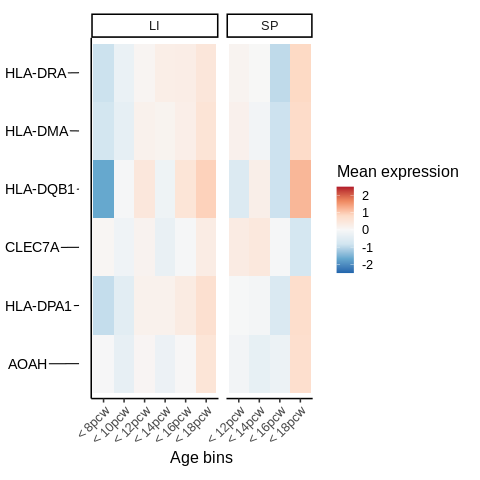

In [493]:
%%R
p2_func

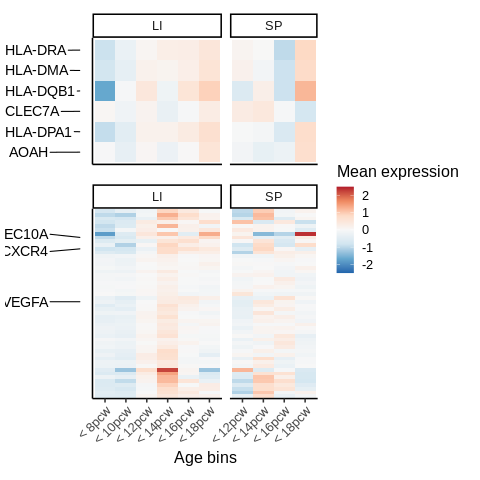

In [494]:
%%R
((p2_func + remove_x_axis()) / (p2_highlight) ) +
plot_layout(guides='collect', heights=c(1,1.5)) +
ggsave(paste0(figdir,"MAC_IV_DE.png"), width=8, height=8) + 
    ggsave(paste0(figdir,"MAC_IV_DE.pdf"), width=8, height=8)

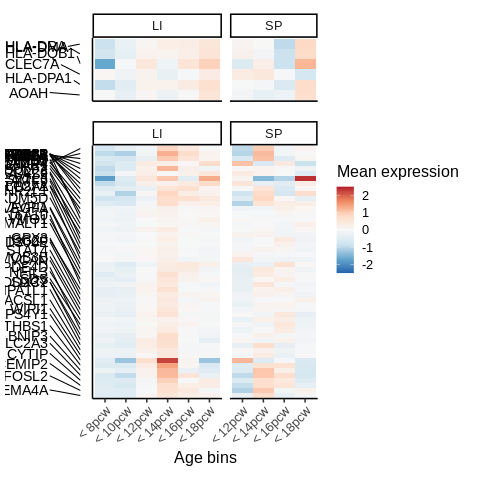

In [495]:
%%R
((p2_func + remove_x_axis()) / (p2_all) ) +
plot_layout(guides='collect', heights=c(1,4)) +
ggsave(paste0(figdir,"MAC_IV_DE_full.png"), width=10, height=18) + 
    ggsave(paste0(figdir,"MAC_IV_DE_full.pdf"), width=10, height=18)

#### Mac V

In [155]:
query_sets = [
    [["MACROPHAGE_V"],["LI"], "signif_early"], 
]

In [156]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [157]:
genes

array(['BIRC5', 'TOP2A', 'CCL23', 'DNASE1L3', 'PVALB', 'GPR182', 'PSMA2',
       'ATP5PO', 'CRHBP', 'MANF', 'PSMB7', 'HSPA5'], dtype=object)

In [36]:
## Save DEG table
df = pd.DataFrame(ordered_genes, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [158]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes 
# high_genes <- c(  "VEGFA", "CXCR4", "CLEC10A", hla_genes)
gex_lims=c(-2.5,2.5)
p2_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes, mean_gex_limits=gex_lims)
# p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, antigen_pres_genes, mean_gex_limits=gex_lims)

Joining, by = c("n_cells", "organ", "age_bins", "gene")
Joining, by = c("organ", "gene")


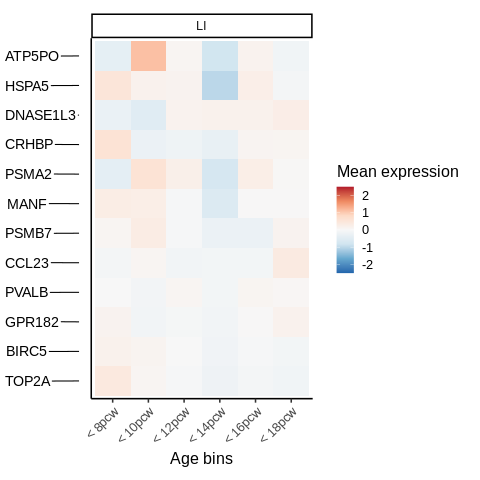

In [160]:
%%R
p2_all

### Plot signatures in all macs

In [101]:
DE_genes_highlight = {
    'iron-recycling':['HMOX1', "BLVRB"],
    "proinflammatory":['IL1A', "CCL4L2", "CCL3L1","TNF", "CCL3", "CCL4", "CXCL8", "NFKBIA", "IL1B"],
    "immune\ndevelopment":["MARCO", 'IFIT2', 
                      "SEMA4A", "NAMPT", "ANXA1"],
    'antigen-presentation':['BTNL9', 'HLA-DRB5', 'HLA-DRA', 'HLA-DPA1', 'C5AR1', 'FPR3', 'FPR2']
                     }

In [102]:
subset_organ = ['LI', "SP", "YS", "GU", "SK", 'BM']
subset_anno = ['MACROPHAGE_TREM2','MACROPHAGE_LYVE1_HIGH', 'MACROPHAGE_PROLIFERATING', 'MACROPHAGE_IRON_RECYCLING', 'MACROPHAGE_MHCII_HIGH', 'MACROPHAGE_KUPFFER_LIKE']

In [107]:
## mean expression
genes = sum([list(x) for x in DE_genes_highlight.values()],[])
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins", 'anno_lvl_2_final_clean'], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins", 'anno_lvl_2_final_clean'], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)
genes = np.array(genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [114]:
X_pl_df['annotation'] = [x[1] for x in X_pl_df['age_bins'].str.split("-")]
X_pl_df['age_bins'] = [x[0] for x in X_pl_df['age_bins'].str.split("-")]

In [115]:
N_pl_df['annotation'] = [x[1] for x in N_pl_df['age_bins'].str.split("-")]
N_pl_df['age_bins'] = [x[0] for x in N_pl_df['age_bins'].str.split("-")]

In [116]:
gene_anno_df = pd.DataFrame([(x,k) for k,v in DE_genes_highlight.items() for x in v])
gene_anno_df.columns = ['gene', 'gene_group']
gene_anno_df.index = gene_anno_df['gene']

In [117]:
gene_anno_df

gene            gene_group
gene                                    
HMOX1        HMOX1        iron-recycling
BLVRB        BLVRB        iron-recycling
IL1A          IL1A       proinflammatory
CCL4L2      CCL4L2       proinflammatory
CCL3L1      CCL3L1       proinflammatory
TNF            TNF       proinflammatory
CCL3          CCL3       proinflammatory
CCL4          CCL4       proinflammatory
CXCL8        CXCL8       proinflammatory
NFKBIA      NFKBIA       proinflammatory
IL1B          IL1B       proinflammatory
MARCO        MARCO   immune\ndevelopment
IFIT2        IFIT2   immune\ndevelopment
SEMA4A      SEMA4A   immune\ndevelopment
NAMPT        NAMPT   immune\ndevelopment
ANXA1        ANXA1   immune\ndevelopment
BTNL9        BTNL9  antigen-presentation
HLA-DRB5  HLA-DRB5  antigen-presentation
HLA-DRA    HLA-DRA  antigen-presentation
HLA-DPA1  HLA-DPA1  antigen-presentation
C5AR1        C5AR1  antigen-presentation
FPR3          FPR3  antigen-presentation
FPR2          FPR2  antigen-presentation

In [118]:
%%R -i figdir -i X_pl_df -i N_pl_df -i genes -i gene_anno_df
gene_anno <- setNames(gene_anno_df$gene_group, gene_anno_df$gene)
# head(gene_anno_df)
highlight_genes <- genes
mean_gex_limits=c(-3,3)
## Plotting function
pl_df <- 
left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU")))  %>%
    mutate(annotation=factor(str_remove(annotation, "MACROPHAGE_"), 
                             levels=c('TREM2','LYVE1_HIGH', 'PROLIFERATING', 'IRON_RECYCLING', 'MHCII_HIGH', 'KUPFFER_LIKE'))) %>%
    mutate(gene_group=gene_anno[as.character(gene)]) %>%
    mutate(gene_group=factor(gene_group, levels=c('iron-recycling', 'proinflammatory', 'immune\ndevelopment',
       'antigen-presentation')))

head(pl_df)

Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
  n_cells organ age_bins     annotation   gene   mean_gex n_cells_gex
1    6893    LI  < 12pcw IRON_RECYCLING  HMOX1 4.81829071        6803
2    6893    LI  < 12pcw IRON_RECYCLING  BLVRB 4.50848103        6803
3    6893    LI  < 12pcw IRON_RECYCLING   IL1A 0.05751302         160
4    6893    LI  < 12pcw IRON_RECYCLING CCL4L2 2.74935484        4334
5    6893    LI  < 12pcw IRON_RECYCLING CCL3L1 2.37443781        4033
6    6893    LI  < 12pcw IRON_RECYCLING    TNF 1.12406170        2633
       gene_group
1  iron-recycling
2  iron-recycling
3 proinflammatory
4 proinflammatory
5 proinflammatory
6 proinflammatory


`summarise()` has grouped output by 'gene', 'age_bins', 'annotation'. You can override using the `.groups` argument.


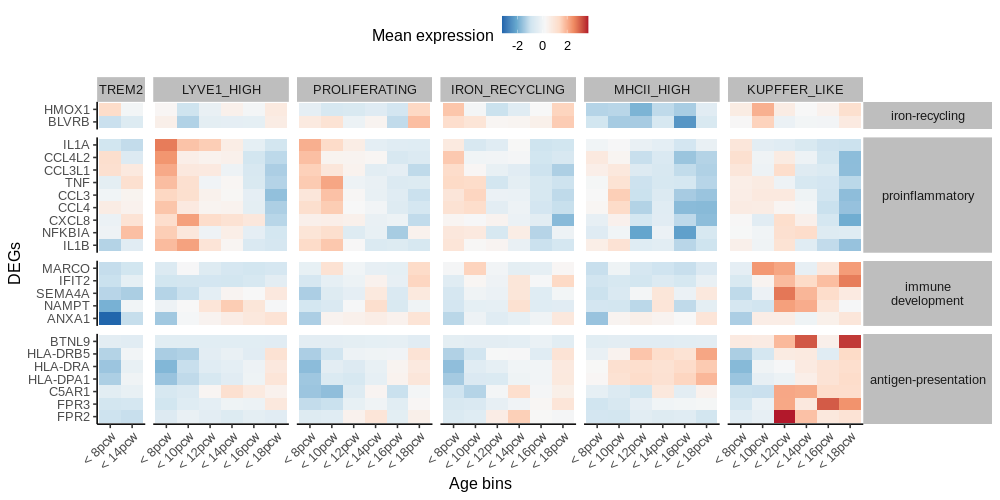

In [124]:
%%R -w 1000 -h 500

# highlight_df <- data.frame(gene=genes, organ='') %>%
#     mutate(highlight=ifelse(gene %in% highlight_genes, gene, NA))

#     highlight_pl <- pl_df %>%
#         full_join(highlight_df) %>%
#         mutate(gene=factor(gene, levels=levels(pl_df$gene))) %>%
#         ggplot(aes(1, gene)) +
#         ggrepel::geom_text_repel(data=. %>% filter(organ==""), aes(label=highlight),
#                                  size=5,
#                                   xlim = c(0.7,0.9), direction = "y", hjust = "left",
#                                 min.segment.length=0) +
#         scale_x_continuous(expand=expansion(mult = c(0.3,0))) +
#         cowplot::theme_nothing() +
#                 theme(plot.margin=margin(0, 0, 0, 0, "cm"))
                
pl1 <- pl_df %>%
    group_by(gene, age_bins, annotation, gene_group) %>%
    summarise(mean_gex=mean(mean_gex), n=n()) %>%
    group_by(gene) %>%
#     mutate(mean_gex=(mean_gex - min(mean_gex))/(max(mean_gex) - min(mean_gex))) %>%
    mutate(mean_gex=(mean_gex - mean(mean_gex))/(sd(mean_gex))) %>%
   ggplot(aes( age_bins, gene)) +
    geom_tile(aes(fill=mean_gex)) +
    facet_grid(gene_group~annotation, space="free", scales="free") +
#         scale_fill_viridis_c(option='magma', direction=-1, name='Mean expression', limits=mean_gex_limits) +
    scale_fill_distiller(palette='RdBu', name='Mean expression') +
    guides(fill=guide_colorbar()) +
    ylab("DEGs") + xlab("Age bins") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1), 
          strip.text.y=element_text(angle=0),
          strip.background=element_rect(fill='grey', color=NA),
          legend.position='top'
          #axis.text.y=element_blank(), axis.ticks.y=element_blank(),
#               plot.margin = unit(c(-1,, -1.2, 0, 0), "cm")
         )

(pl1) 
#     ggsave(paste0(figdir,"macs_figure.png"), width=15, height=12) 

In [125]:
%%R -w 1000 -h 500
organ_colors_df <- read.csv("~/Pan_fetal_immune/metadata/organ_colors.csv")
organ_palette <- setNames(organ_colors_df$color, organ_colors_df$organ)

pl2 <- pl_df %>%
    ungroup() %>%
    distinct(age_bins, organ, annotation, n_cells) %>%
    group_by(age_bins, organ) %>%
    mutate(n_macs=sum(n_cells)) %>%
    ungroup() %>%
    ggplot(aes(age_bins, n_cells/n_macs, color=organ, fill=organ)) +
    geom_point(aes(size=n_cells)) +
    geom_line(aes(group=organ)) +
    scale_fill_manual(values=organ_palette) +
    scale_color_manual(values=organ_palette) +
    facet_grid(.~annotation, scales='free_x', space="free") +
    theme_classic(base_size=16) +
    ylab("Fraction of\nMacrophages") +
    theme(legend.position='top')

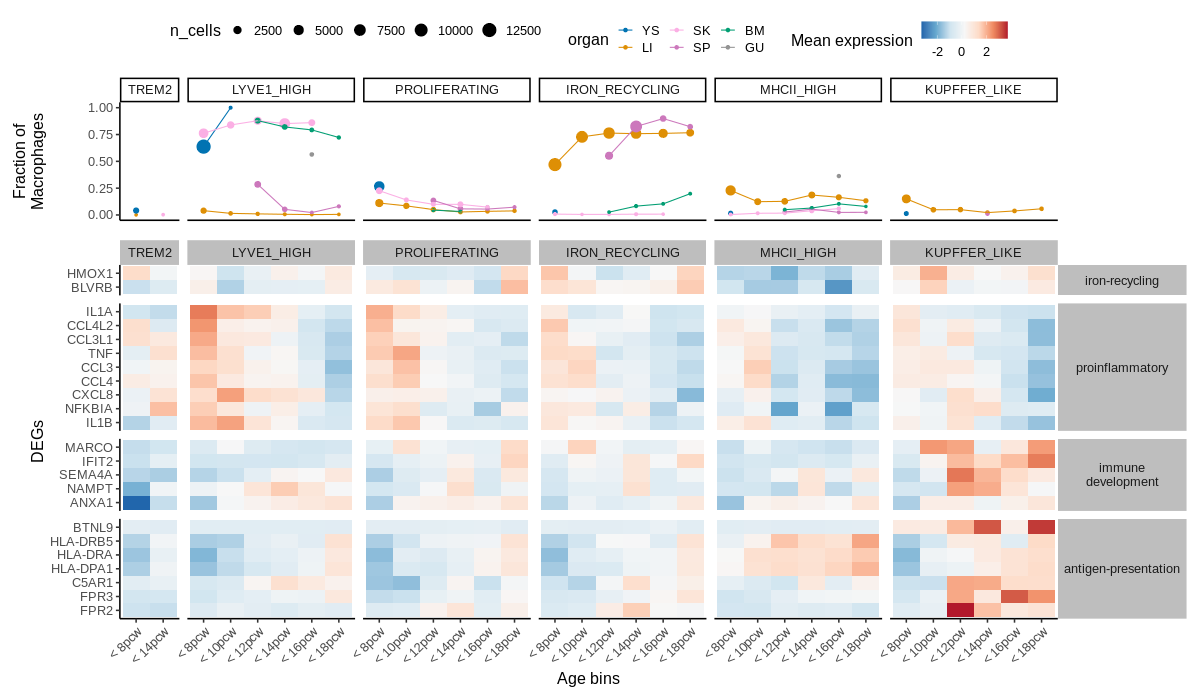

In [130]:
%%R -w 1200 -h 700
((pl2 + remove_x_axis()) / pl1 +
    plot_layout(heights=c(1,3), guides='collect') &
    theme(legend.position='top')) +
    ggsave(paste0(figdir, 'all_macs.pdf'), width=13, height=10) +
    ggsave(paste0(figdir, 'all_macs.png'), width=13, height=10)

### Enrichment analysis

In [178]:
# pip install gseapy

In [174]:
%matplotlib inline
%config InlineBackend.figure_format='retina' # mac
%load_ext autoreload
%autoreload 2
import gseapy as gp
from gseapy.plot import barplot, dotplot

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Creating directory /home/jovyan/.config/bioservices 


In [175]:
gp.__version__

'0.10.5'

In [176]:
names = gp.get_library_name() # default: Human

In [184]:
infile = 'DEGS_MACROPHAGE_I_SK-LI.csv'

In [216]:
gene_sets=['GO_Biological_Process_2021']

In [217]:
# run enrichr
# if you are only intrested in dataframe that enrichr returned, please set no_plot=True
for infile in [x for x in os.listdir(outdir) if x.startswith("DEG")]:
    id_name = infile.split(".csv")[0]
    DGE = pd.read_csv(outdir+infile) 
    gene_list = list(DGE['DEG'])
    # list, dataframe, series inputs are supported
    enr = gp.enrichr(gene_list=gene_list,
                     gene_sets=gene_sets,
                     organism='Human', # don't forget to set organism to the one you desired! e.g. Yeast
                     description=id_name,
                     outdir='enrichr/'+id_name+'/',
                     # no_plot=True,
                     cutoff=0.5 # test dataset, use lower value from range(0,1)
                    )
    # to save your figure, make sure that ``ofname`` is not Nonea
    ax=dotplot(enr.res2d, title='MSigDB_Hallmark_2020',cmap='RdYlBu_r',cutoff=1, top_terms=10,
               figsize=(6,6),
               ofname=figdir + id_name + '.enrichr.pdf')

In [207]:
genes = enr.res2d["Genes"][0].split(";")

In [382]:
id_name="DEGS_MACROPHAGE_II_SP-LI"
enr_res = pd.read_table('enrichr/'+id_name+'/GO_Biological_Process_2021.Human.enrichr.reports.txt')
enr_res[0:20]

Gene_set  \
0   GO_Biological_Process_2021   
1   GO_Biological_Process_2021   
2   GO_Biological_Process_2021   
3   GO_Biological_Process_2021   
4   GO_Biological_Process_2021   
5   GO_Biological_Process_2021   
6   GO_Biological_Process_2021   
7   GO_Biological_Process_2021   
8   GO_Biological_Process_2021   
9   GO_Biological_Process_2021   
10  GO_Biological_Process_2021   
11  GO_Biological_Process_2021   
12  GO_Biological_Process_2021   
13  GO_Biological_Process_2021   
14  GO_Biological_Process_2021   
15  GO_Biological_Process_2021   
16  GO_Biological_Process_2021   
17  GO_Biological_Process_2021   
18  GO_Biological_Process_2021   
19  GO_Biological_Process_2021   

                                                 Term Overlap   P-value  \
0   complement receptor mediated signaling pathway...    3/11  0.000002   
1   interferon-gamma-mediated signaling pathway (G...    4/68  0.000025   
2   immune response-activating cell surface recept...    3/24  0.000029   
3   negative regulation of keratinocyte proliferat...     2/8  0.000170   
4   heparan sulfate proteoglycan biosynthetic proc...     2/8  0.000170   
5   cellular response to interferon-gamma (GO:0071...   4/121  0.000237   
6      T cell receptor signaling pathway (GO:0050852)   4/158  0.000651   
7   heparan sulfate proteoglycan biosynthetic proc...    2/19  0.001019   
8   phospholipase C-activating G protein-coupled r...    3/81  0.001094   
9   antigen receptor-mediated signaling pathway (G...   4/185  0.001171   
10  heparan sulfate proteoglycan metabolic process...    2/21  0.001248   
11            microglial cell activation (GO:0001774)    2/22  0.001370   
12  regulation of keratinocyte proliferation (GO:0...    2/24  0.001632   
13  cellular polysaccharide biosynthetic process (...    2/25  0.001771   
14  antigen processing and presentation of exogeno...    3/98  0.001892   
15  positive regulation of protein modification pr...   4/214  0.001997   
16  antigen processing and presentation of peptide...   3/100  0.002005   
17  antigen processing and presentation of exogeno...   3/103  0.002181   
18     proteoglycan biosynthetic process (GO:0030166)    2/31  0.002719   
19  positive regulation of phosphorylation (GO:004...   4/253  0.003649   

    Adjusted P-value  Old P-value  Old Adjusted P-value  Odds Ratio  \
0           0.000897            0                     0  159.111702   
1           0.003584            0                     0   27.019022   
2           0.003584            0                     0   60.574468   
3           0.012740            0                     0  138.500000   
4           0.012740            0                     0  138.500000   
5           0.014797            0                     0   14.740245   
6           0.034865            0                     0   11.177866   
7           0.042538            0                     0   48.855392   
8           0.042538            0                     0   16.261866   
9           0.042538            0                     0    9.497478   
10          0.042538            0                     0   43.708333   
11          0.042824            0                     0   41.520833   
12          0.044221            0                     0   37.742424   
13          0.044221            0                     0   36.099638   
14          0.044221            0                     0   13.340426   
15          0.044221            0                     0    8.173913   
16          0.044221            0                     0   13.064049   
17          0.045438            0                     0   12.670213   
18          0.053670            0                     0   28.622126   
19          0.065267            0                     0    6.880042   

    Combined Score                            Genes  
0      2059.464527                  C5AR1;FPR3;FPR2  
1       286.295794   HLA-DRB5;HLA-DRA;MID1;HLA-DPA1  
2       633.579375                  C5AR1;FPR3;FPR2  
3      1202.251780     

In [209]:
id_name="DEGS_MACROPHAGE_IV_SP-LI"
enr_res = pd.read_table('enrichr/'+id_name+'/MSigDB_Hallmark_2020.Human.enrichr.reports.txt')
enr_res

Gene_set                               Term Overlap  \
0   MSigDB_Hallmark_2020                            Hypoxia   9/200   
1   MSigDB_Hallmark_2020      TNF-alpha Signaling via NF-kB   7/200   
2   MSigDB_Hallmark_2020                   mTORC1 Signaling   5/200   
3   MSigDB_Hallmark_2020                         Glycolysis   5/200   
4   MSigDB_Hallmark_2020          Interferon Gamma Response   4/200   
5   MSigDB_Hallmark_2020  Epithelial Mesenchymal Transition   4/200   
6   MSigDB_Hallmark_2020                       Angiogenesis    2/36   
7   MSigDB_Hallmark_2020                          Apoptosis   3/161   
8   MSigDB_Hallmark_2020              Inflammatory Response   3/200   
9   MSigDB_Hallmark_2020           PI3K/AKT/mTOR  Signaling   2/105   
10  MSigDB_Hallmark_2020          Unfolded Protein Response   2/113   
11  MSigDB_Hallmark_2020                        Coagulation   2/138   
12  MSigDB_Hallmark_2020                     UV Response Dn   2/144   
13  MSigDB_Hallmark_2020              Fatty Acid Metabolism   2/158   
14  MSigDB_Hallmark_2020                     UV Response Up   2/158   
15  MSigDB_Hallmark_2020                 Hedgehog Signaling    1/36   
16  MSigDB_Hallmark_2020               IL-2/STAT5 Signaling   2/199   
17  MSigDB_Hallmark_2020                         Myogenesis   2/200   
18  MSigDB_Hallmark_2020                     Apical Surface    1/44   
19  MSigDB_Hallmark_2020    Reactive Oxygen Species Pathway    1/49   
20  MSigDB_Hallmark_2020                 TGF-beta Signaling    1/54   
21  MSigDB_Hallmark_2020            Cholesterol Homeostasis    1/74   
22  MSigDB_Hallmark_2020                  Protein Secretion    1/96   
23  MSigDB_Hallmark_2020          Interferon Alpha Response    1/97   
24  MSigDB_Hallmark_2020                        Pperoxisome   1/104   
25  MSigDB_Hallmark_2020               Bile Acid Metabolism   1/112   
26  MSigDB_Hallmark_2020                       Adipogenesis   1/200   
27  MSigDB_Hallmark_2020            Estrogen Response Early   1/200   
28  MSigDB_Hallmark_2020             Estrogen Response Late   1/200   
29  MSigDB_Hallmark_2020                    Apical Junction   1/200   
30  MSigDB_Hallmark_2020                        p53 Pathway   1/200   
31  MSigDB_Hallmark_2020                    heme Metabolism   1/200   
32  MSigDB_Hallmark_2020                Allograft Rejection   1/200   
33  MSigDB_Hallmark_2020                  KRAS Signaling Up   1/200   

         P-value  Adjusted P-value  Old P-value  Old Adjusted P-value  \
0   1.467690e-09      4.990147e-08            0                     0   
1   6.247575e-07      1.062088e-05            0                     0   
2   1.398365e-04      1.188610e-03            0                     0   
3   1.398365e-04      1.188610e-03            0                     0   
4   1.559881e-03      8.839324e-03            0                     0   
5   1.559881e-03      8.839324e-03            0                     0   
6   3.654926e-03      1.775250e-02            0                     0   
7   7.608098e-03      3.233442e-02            0                     0   
8   1.367863e-02      5.167481e-02            0                     0   
9   2.839804e-02      9.655335e-02            0                     0   
10  3.250110e-02      1.004579e-01            0                     0   
11  4.668480e-02      1.317453e-01            0                     0   
12  5.037319e-02      1.317453e-01            0                     0   
13  5.936997e-02      1.345719e-01            0                     0   
14  5.936997e-02      1.345719e-01            0                     0   
15  8.624372e-02      1.685672e-01            0                     0   
16  8.848583e-02      1.685672e-01            0                     0   
17  8.924145e-02      1.685672e-01            0                     0   
18  1.043952e-01      1.868125e-01            0                     0   
19  1.155600e-01      1.964520e-01            0                     0 

### Signatures in mast cells

In [284]:
subset_organ = ['LI']
subset_anno = ['MAST_CELL']

In [285]:
condition = 'signif_early'
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=1,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'Sample.lanes' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'orig.ident' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sort.ids' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'origin' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'count' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'total_live_events' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'sort_sample_id' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical


In [286]:
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)
## mean expression
# subset_organ=['YS', "LI", "SK", "SP"]
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))
    test_adata = adata[cells_in_org]
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

## Cluster genes
from scipy.cluster.hierarchy import ward, dendrogram, leaves_list

# for i in range(len(query_sets)):
# subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
df = X_pl_df.drop(['n_cells', 'organ', 'age_bins'], 1).T
clustering = ward(df.values)
ordered_genes = df.index[leaves_list(clustering)].tolist()
X_pl_df = X_pl_df[ordered_genes + ['n_cells', 'organ', 'age_bins'] ]
ordered_genes = np.array(ordered_genes)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [247]:
## Save DEG table
df = pd.DataFrame(ordered_genes, columns=['DEG'])
df['annotation'] = subset_anno[0]
df['organs'] = "-".join(subset_organ)
df.to_csv(outdir + "DEGS_{a}_{o}.csv".format(a=subset_anno[0], o=df['organs'][0]))

In [275]:
X_pl_df['annotation'] = "MAST_CELL"
N_pl_df['annotation'] = "MAST_CELL"

In [277]:
N_pl_df = N_pl_df[N_pl_df['n_cells'] > 30]
X_pl_df = X_pl_df[X_pl_df['n_cells'] > 30]

Trying to set attribute `.obs` of view, copying.
... storing 'Sample.lanes' as categorical
... storing 'orig.ident' as categorical
... storing 'sort.ids' as categorical
... storing 'origin' as categorical
... storing 'count' as categorical
... storing 'total_live_events' as categorical
... storing 'sort_sample_id' as categorical
... storing 'age_bins' as categorical


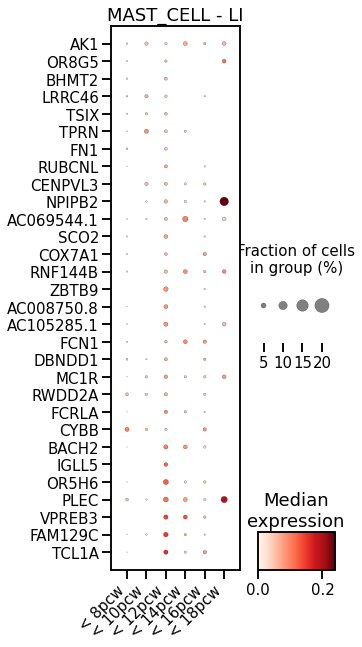

In [287]:
plot_DGE(test_adata, dge_df, subset_organ, subset_anno)

Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
Joining, by = c("organ", "gene")


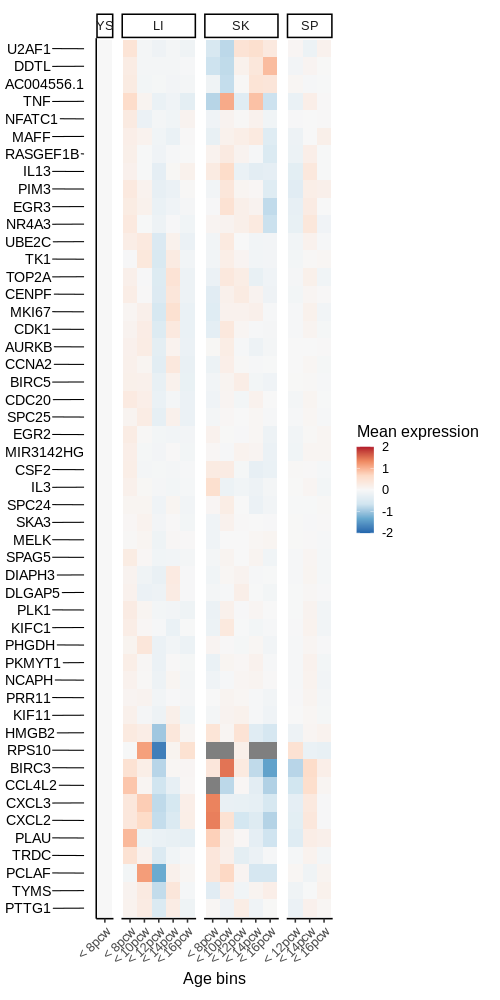

In [279]:
%%R -i figdir -i X_pl_df -i N_pl_df -i ordered_genes -h 1000 -w 500
# high_genes <- c(  "VEGFA", "CXCR4", "CLEC10A", hla_genes)
gex_lims=c(-2,2)
p2_all <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, ordered_genes, mean_gex_limits=gex_lims)
p2_all
# p2_highlight <- plot_time_highlight(X_pl_df, N_pl_df, ordered_genes, antigen_pres_genes, mean_gex_limits=gex_lims)

---

#### Late Macs

spl and liver Mac_IV and Mac_II

In [419]:
query_sets = [
    [["MACROPHAGE_II"],["SP"], "signif_late"], 
    [["MACROPHAGE_II"],["LI"], "signif_late"], 
    [["MACROPHAGE_IV"],["LI"], "signif_late"], 
]

for i in range(len(query_sets)):
    subset_anno, subset_organ, condition = query_sets[i]
    test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                      max_frac=0.7,
                                      test_type='vs_rest')
    test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

    genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0.25)
    ## mean expression
    X_df_ls = []
    for org in subset_organ:
        pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
        X_df = pd.DataFrame(pbulk_adata.X.toarray())
        X_df.columns = genes
        X_df.index = pbulk_adata.obs_names
        X_df['n_cells'] = pbulk_adata.obs["n_cells"]
        X_df['organ'] = org
        X_df['age_bins'] = pbulk_adata.obs['age_bins']
    #     X_df['age'] = pbulk_adata.obs['age']
        X_df_ls.append(X_df)
    X_pl_df = pd.concat(X_df_ls)

    ## n_cells expressing
    X_df_ls = []
    for org in subset_organ:
        pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
        X_df = pd.DataFrame(pbulk_adata.X.toarray())
        X_df.columns = genes
        X_df.index = pbulk_adata.obs_names
        X_df['n_cells'] = pbulk_adata.obs["n_cells"]
        X_df['organ'] = org
        X_df['age_bins'] = pbulk_adata.obs['age_bins']
    #     X_df['age'] = pbulk_adata.obs['age']
        X_df_ls.append(X_df)
    N_pl_df = pd.concat(X_df_ls)
    query_sets[i].append(X_pl_df)
    query_sets[i].append(N_pl_df)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [420]:
for i in range(len(query_sets)):
    subset_anno, subset_organ, condition, X_pl_df, N_pl_df = query_sets[i]
    X_pl_df['annotation'] = subset_anno[0]
    N_pl_df['annotation'] = subset_anno[0]

X_pl_df_ls = [x[3] for x in query_sets]
N_pl_df_ls = [x[4] for x in query_sets]

Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
Joining, by = c("organ", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
Joining, by = c("organ", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
Joining, by = c("organ", "gene")
[[1]]

[[2]]

[[3]]



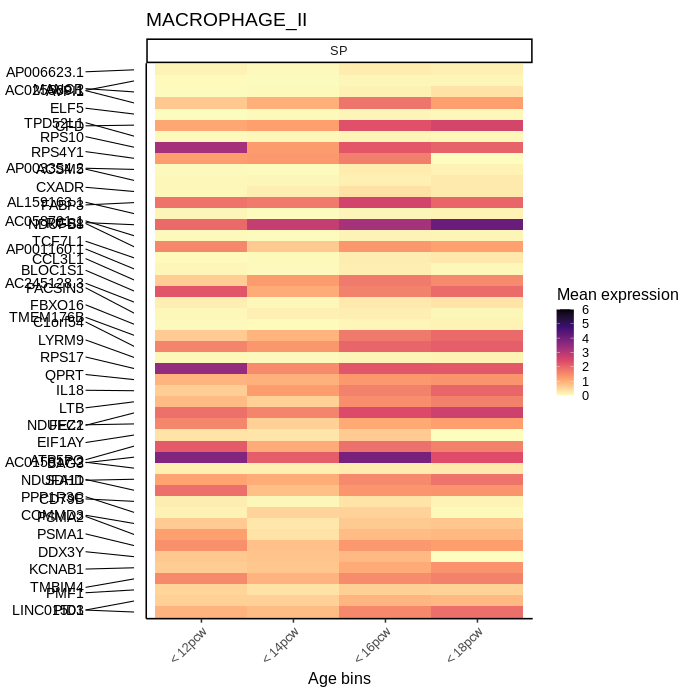

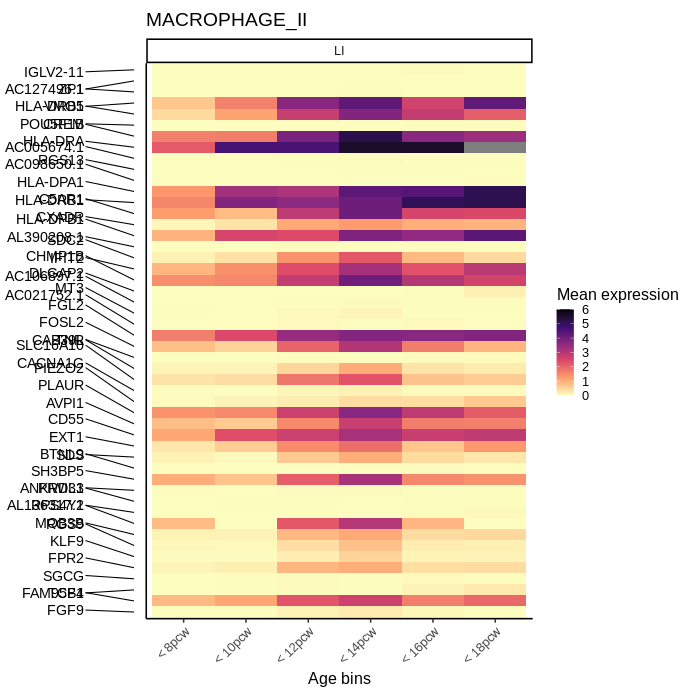

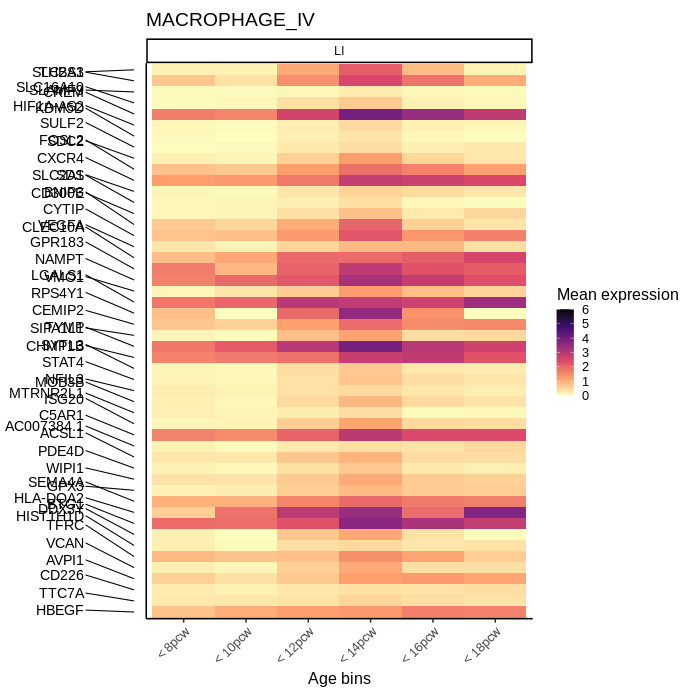

In [421]:
%%R -i X_pl_df_ls -i N_pl_df_ls -i genes -i cut_labels_4 -i figdir -w 700 -h 700

# X_pl_df_ls[[1]] %>% 
# long_N_pl_df %>%
#     filter(annotation==anno & organ==org) %>%
#     filter(gene %in% keep_genes) %>%
#     head()
pl_ls <- lapply(1:length(X_pl_df_ls), function(i){
    genes = colnames(X_pl_df_ls[[i]])[1:(ncol(X_pl_df_ls[[i]])-4)]
    plot_time_highlight(X_pl_df_ls[[i]], N_pl_df_ls[[i]], genes, highlight_genes=genes, mean_gex_limits=c(0,6)) +
    ggtitle(X_pl_df_ls[[i]]$annotation[1]) +
    ggsave(paste0(figdir,X_pl_df_ls[[i]]$organ[1], "_", X_pl_df_ls[[i]]$annotation[1], "_cells_DEGs.png"), width=8, height=12) + 
    ggsave(paste0(figdir,X_pl_df_ls[[i]]$organ[1], "_", X_pl_df_ls[[i]]$annotation[1], "_cells_DEGs.pdf"), width=8, height=12)

})
pl_ls

Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
Joining, by = c("organ", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
Joining, by = c("organ", "gene")
Joining, by = c("n_cells", "organ", "age_bins", "annotation", "gene")
Joining, by = c("organ", "gene")
[[1]]

[[2]]

[[3]]



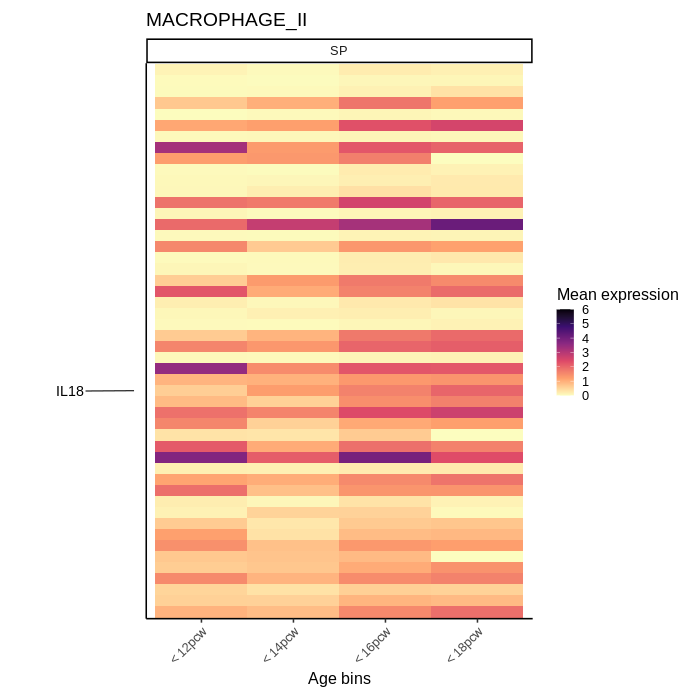

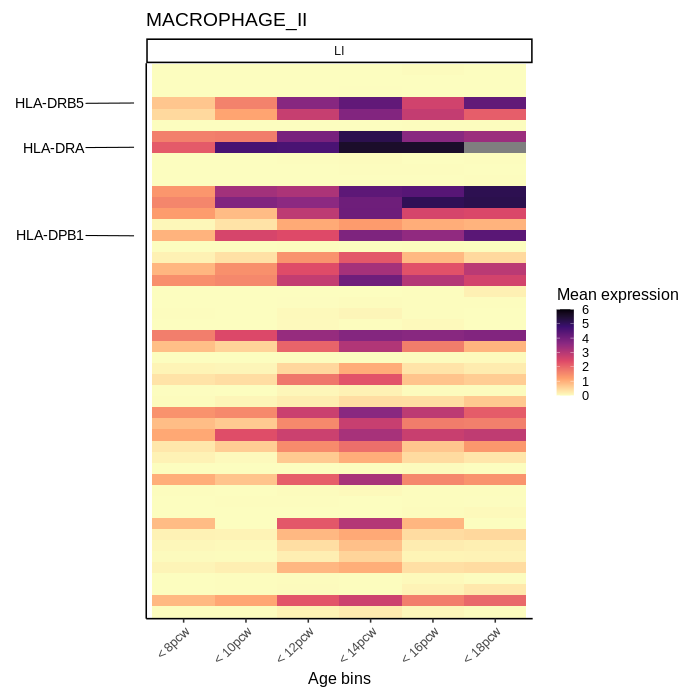

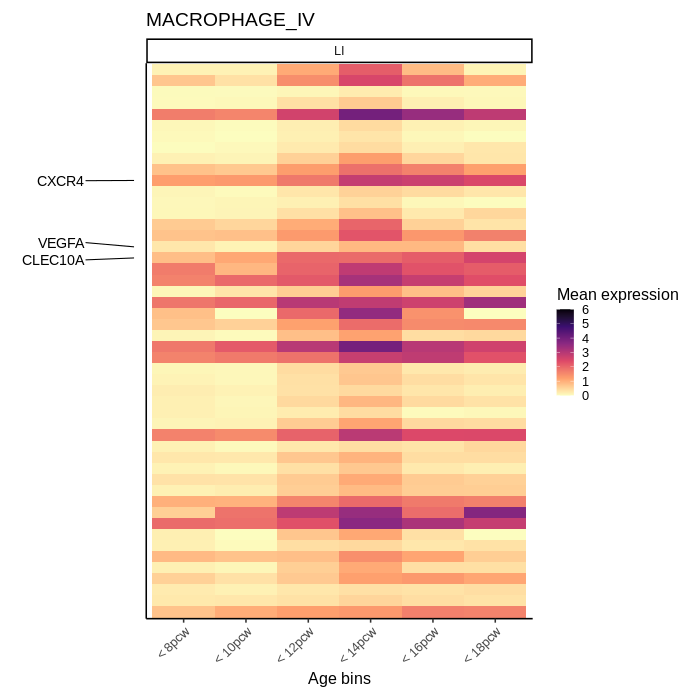

In [423]:
%%R -i X_pl_df_ls -i N_pl_df_ls -i cut_labels_4 -i figdir -w 700 -h 700

antigen_pres_genes <- c("HLA-DRA", "HLA-DRB5","HLA-DPB1","IL18",  "VEGFA", "CXCR4", "CLEC10A")

pl_ls <- lapply(1:length(X_pl_df_ls), function(i){
    genes = colnames(X_pl_df_ls[[i]])[1:(ncol(X_pl_df_ls[[i]])-4)]
    plot_time_highlight(X_pl_df_ls[[i]], N_pl_df_ls[[i]], genes, highlight_genes=antigen_pres_genes, mean_gex_limits=c(0,6)) +
    ggtitle(X_pl_df_ls[[i]]$annotation[1]) +
    ggsave(paste0(figdir,X_pl_df_ls[[i]]$organ[1], "_", X_pl_df_ls[[i]]$annotation[1], "_cells_DEGs_highlight.png"), width=6, height=6) + 
    ggsave(paste0(figdir,X_pl_df_ls[[i]]$organ[1], "_", X_pl_df_ls[[i]]$annotation[1], "_cells_DEGs_highlight.pdf"), width=6, height=6)

})
pl_ls

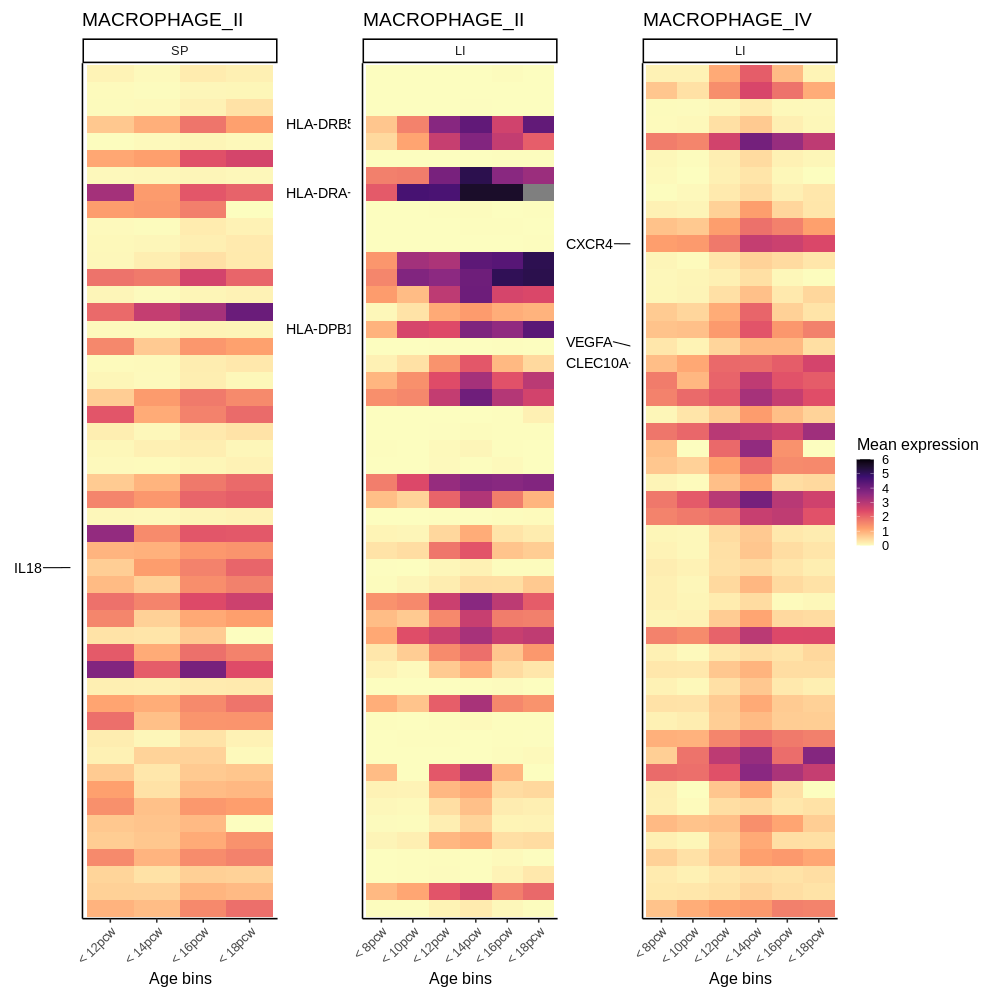

In [425]:
%%R -h 1000 -w 1000
wrap_plots(pl_ls[1:3]) +
plot_layout(guides='collect', ncol=3) +
    ggsave(paste0(figdir,"late_MACs_De.png"), width=13, height=5) + 
    ggsave(paste0(figdir,"late_MACs_De.pdf"), width=13, height=5)

In [ ]:
## Provided by Laura
mac_functional_genes = {
    'iron_recycling':{
        'SLC40A1', "SLC48A1", 'TIMD4', "CD163","LRP1", "FTH1", "HMOX1",
        "BLVRA", "BLVRB", "SLC11A1", "SLC11A2", "SPIC", "VCAM1", "CSF1R",
        "PCBP2"
    },
    'LYVEhi_macs':{
        'LYVE1', "F13A1", "SPP1", "CCL4", "MRC1", "STAB1", "LIPA"
    },
    'class_II':{
        'HLA-DPA1',"HLA-DRA", "HLA-DMA", "HLA-DQB1", "CLEC7A", "AOAH"
    }
}

---

In [304]:
long_X_pl_df = pd.concat([x[3] for x in query_sets])
long_N_pl_df = pd.concat([x[4] for x in query_sets])

Joining, by = c("annotation", "age_bins", "organ", "n_cells", "gene")
Joining, by = c("annotation", "age_bins", "organ", "n_cells", "gene")
Joining, by = c("annotation", "age_bins", "organ", "n_cells", "gene")


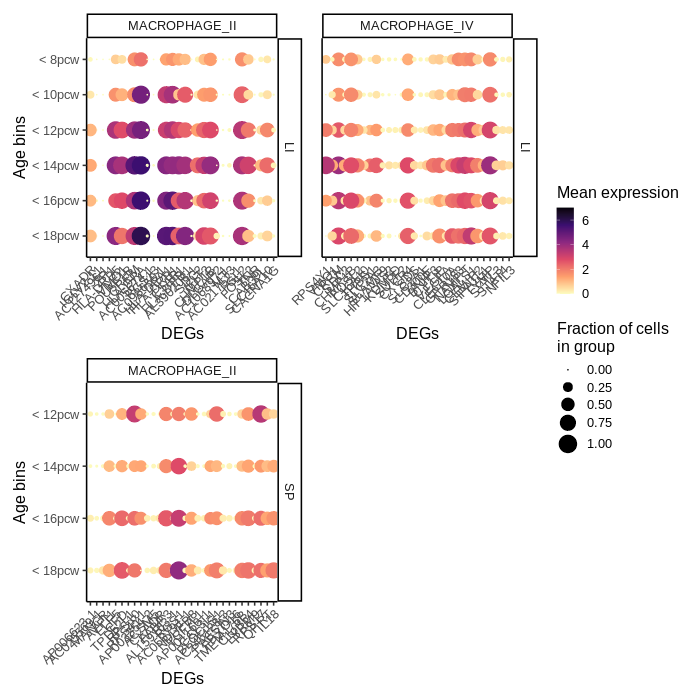

In [305]:
%%R -i long_X_pl_df -i long_N_pl_df -i genes -i cut_labels_4 -i figdir -w 700 -h 700

scale_to_1 <- function(x){
    scaled_x = (x - min(x))/(max(x)- min(x))
    return(scaled_x)
}


# # pl1
# pl1 +
#  ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.png"), width=6, height=8) + 
#     ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.pdf"), width=6, height=8)
(plot_time_dotplot(long_X_pl_df, long_N_pl_df, org="LI", anno="MACROPHAGE_II")) +
(plot_time_dotplot(long_X_pl_df, long_N_pl_df, org="LI", anno="MACROPHAGE_IV") +remove_y_axis()) +
(plot_time_dotplot(long_X_pl_df, long_N_pl_df, org="SP", anno="MACROPHAGE_II") ) +
plot_layout(ncol=2, nrow=2, guides="collect") +
ggsave(paste0(figdir, "late_MACs.png"), width=17, height=8) + 
ggsave(paste0(figdir, "late_MACs.pdf"), width=17, height=8) 
#     ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.pdf"), width=6, height=8)

---

In [170]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=30,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in ["SK"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["SK"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


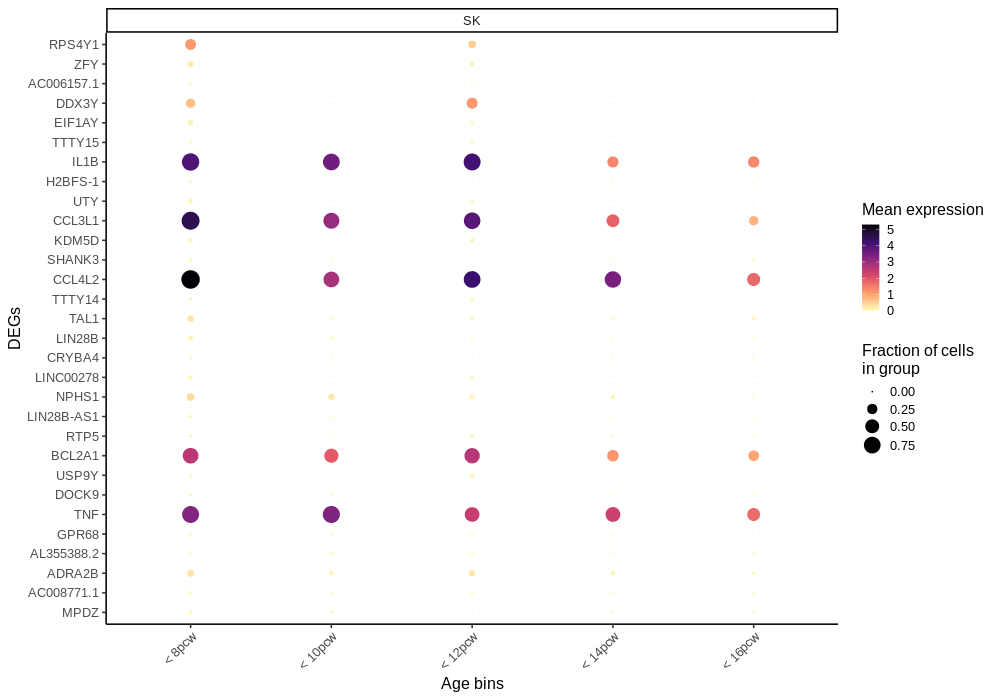

In [171]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl2 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl2 +
 ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.png"), width=6, height=8) + 
    ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.pdf"), width=6, height=8)

#### Liver/Spleen Macs

In [174]:
query_sets = [
    (["MACROPHAGE_II"],["LI"], "signif_early"), 
    (["MACROPHAGE_II"],["LI"], "signif_late"), 
]

In [182]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

In [182]:
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in ["LI"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["LI"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


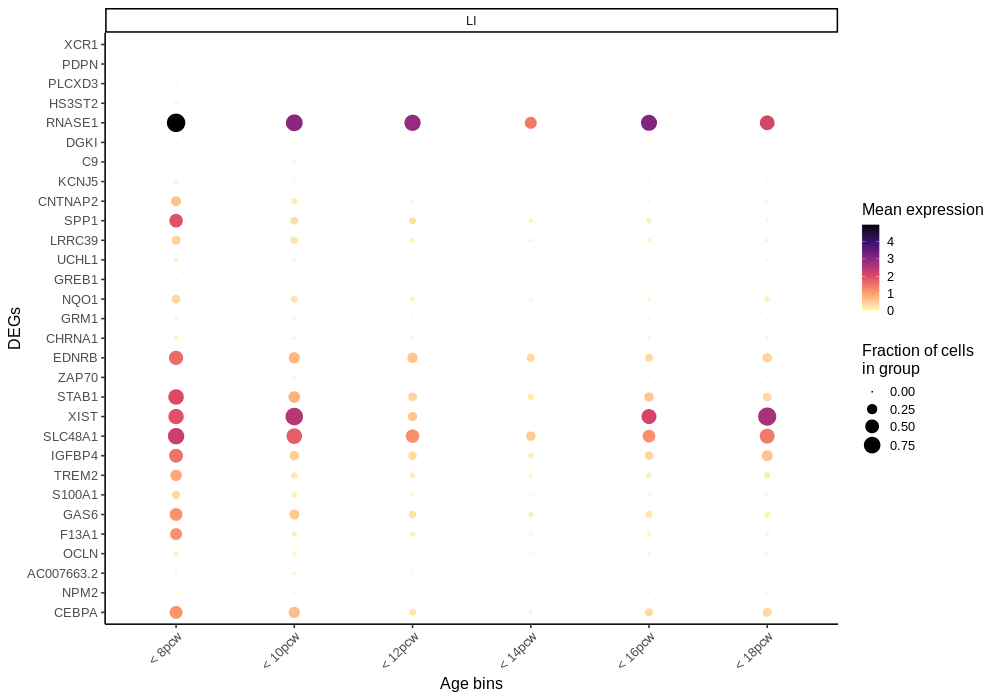

In [183]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl1 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl1 
#  ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.png"), width=6, height=12) + 
#     ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.pdf"), width=6, height=12)

In [184]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

In [190]:
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


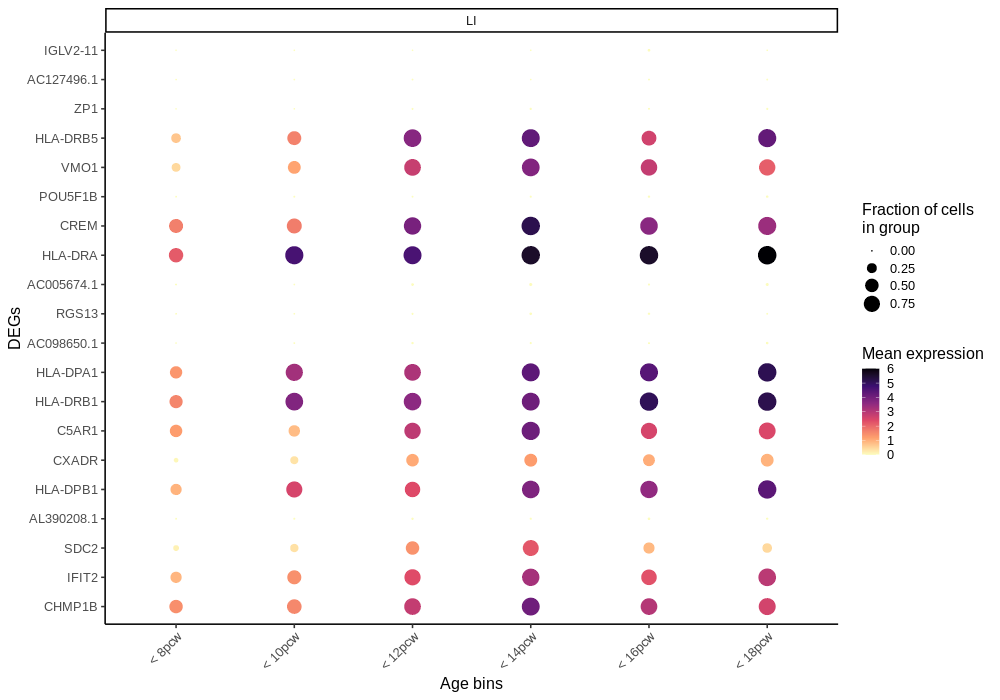

In [191]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl2 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl2 
# +
#  ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.png"), width=6, height=8) + 
#     ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.pdf"), width=6, height=8)

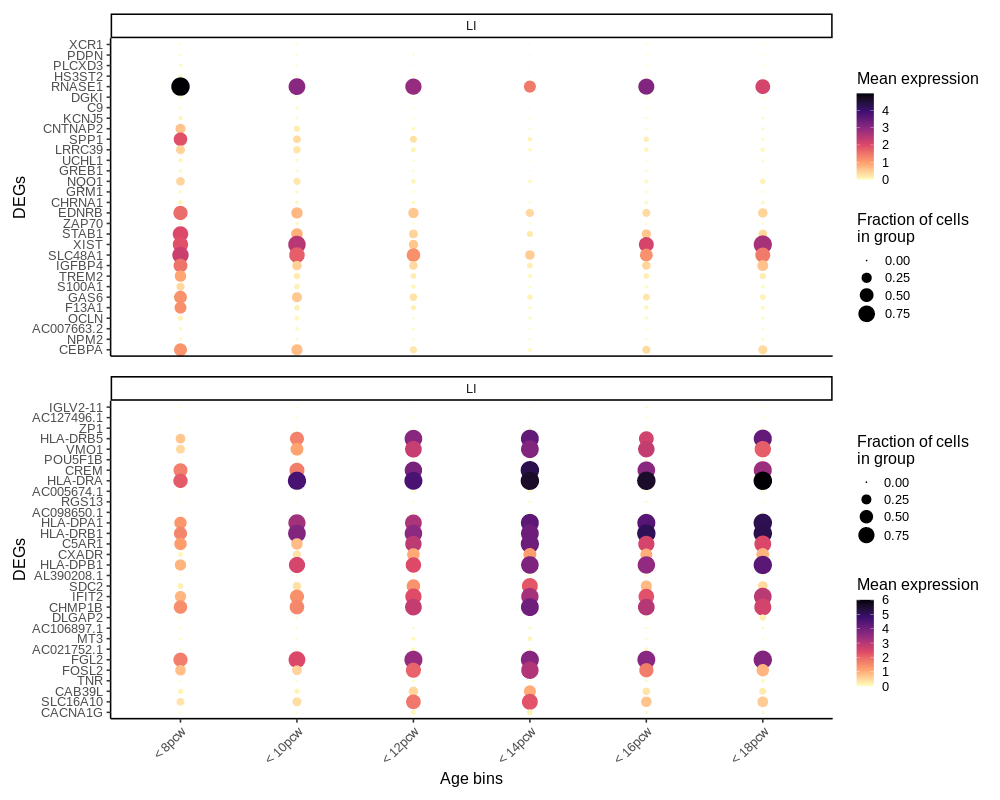

In [185]:
%%R -w 1000 -h 800
((pl1 + remove_x_axis()) / pl2) +
 ggsave(paste0(figdir, "MACII_LI_cells_DEGs.png"), width=6, height=8) + 
    ggsave(paste0(figdir, "MACII_LI_cells_DEGs.pdf"), width=6, height=8) 


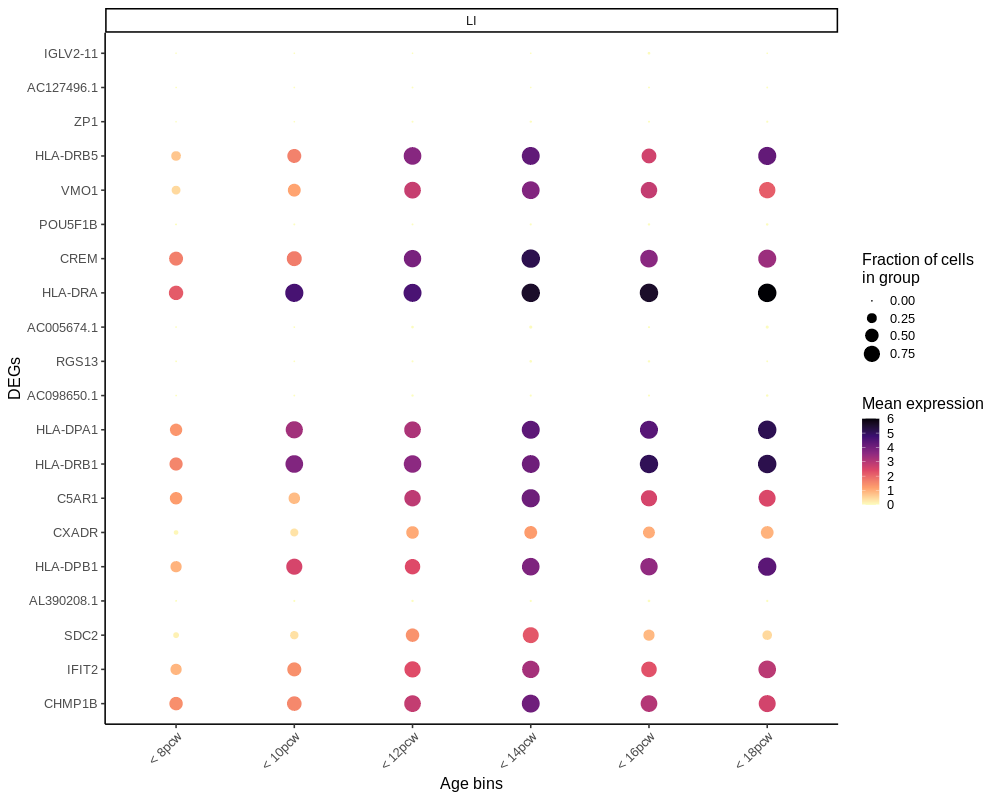

In [192]:
%%R -w 1000 -h 800
(pl2) +
 ggsave(paste0(figdir, "MACII_late_LI_cells_DEGs.png"), width=6, height=8) + 
    ggsave(paste0(figdir, "MACII_late_LI_cells_DEGs.pdf"), width=6, height=8) 


In [193]:
query_sets = [
    (["MACROPHAGE_II"],["SP"], "signif_late"), 
    ]

In [194]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.8,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

In [196]:
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=30,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


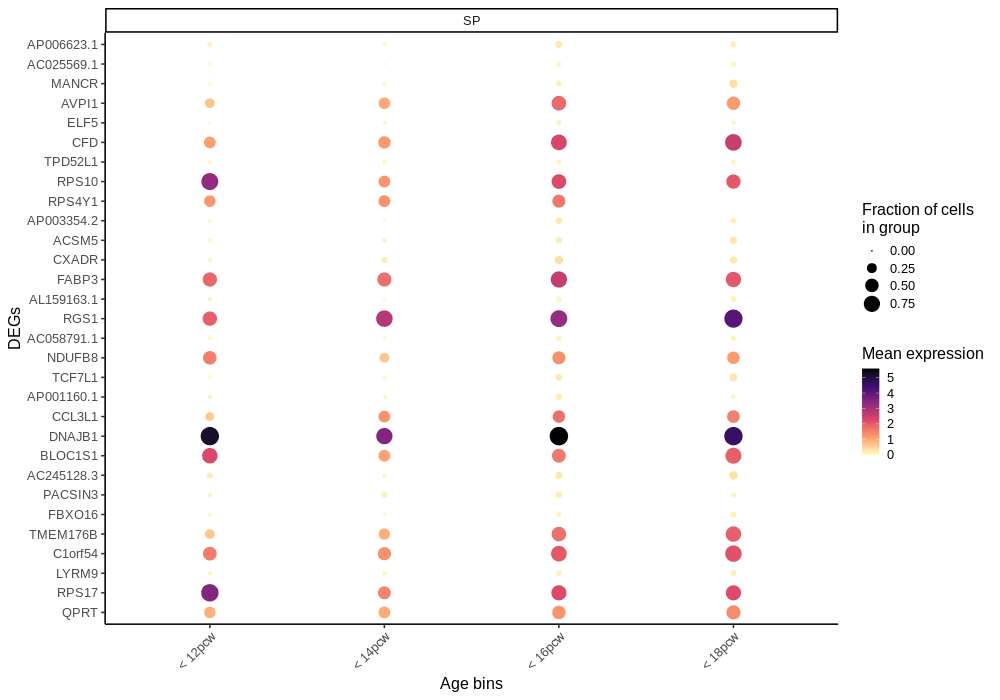

In [197]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl1 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl1 +
 ggsave(paste0(figdir, "SP_MAC_II_cells_DEGs.png"), width=6, height=8) + 
    ggsave(paste0(figdir, "SP_MAC_II_cells_DEGs.pdf"), width=6, height=8)

#### Mac IV in liver

In [198]:
query_sets = [
    (["MACROPHAGE_IV"],["LI"], "signif_early"), 
    (["MACROPHAGE_IV"],["LI"], "signif_late"), 
]

In [102]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in ["LI"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["LI"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


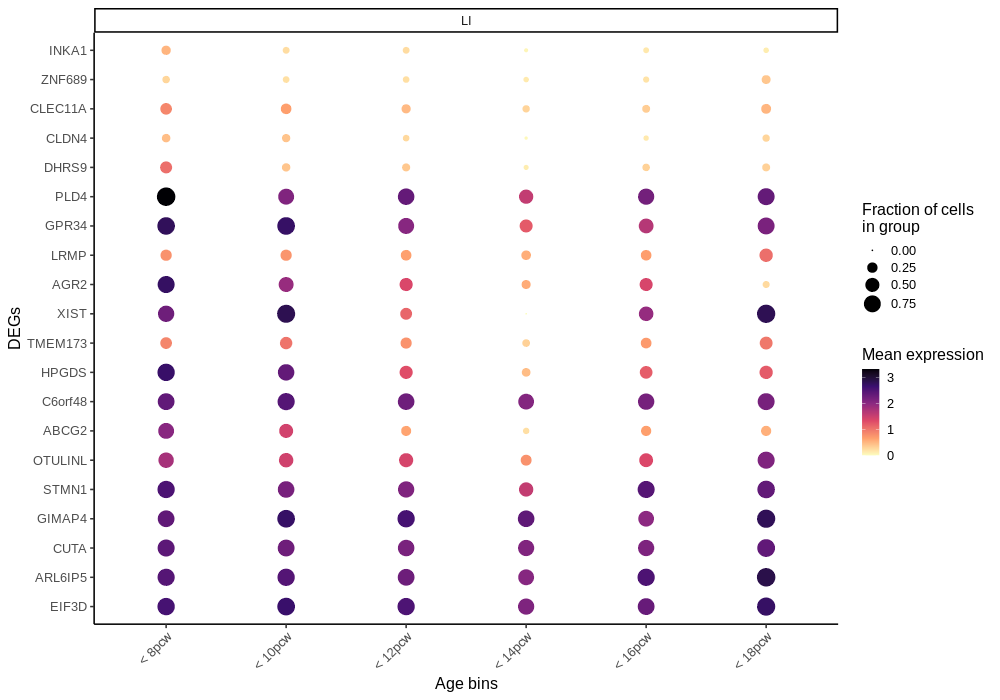

In [103]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl1 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl1 
#  ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.png"), width=6, height=12) + 
#     ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.pdf"), width=6, height=12)

In [199]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


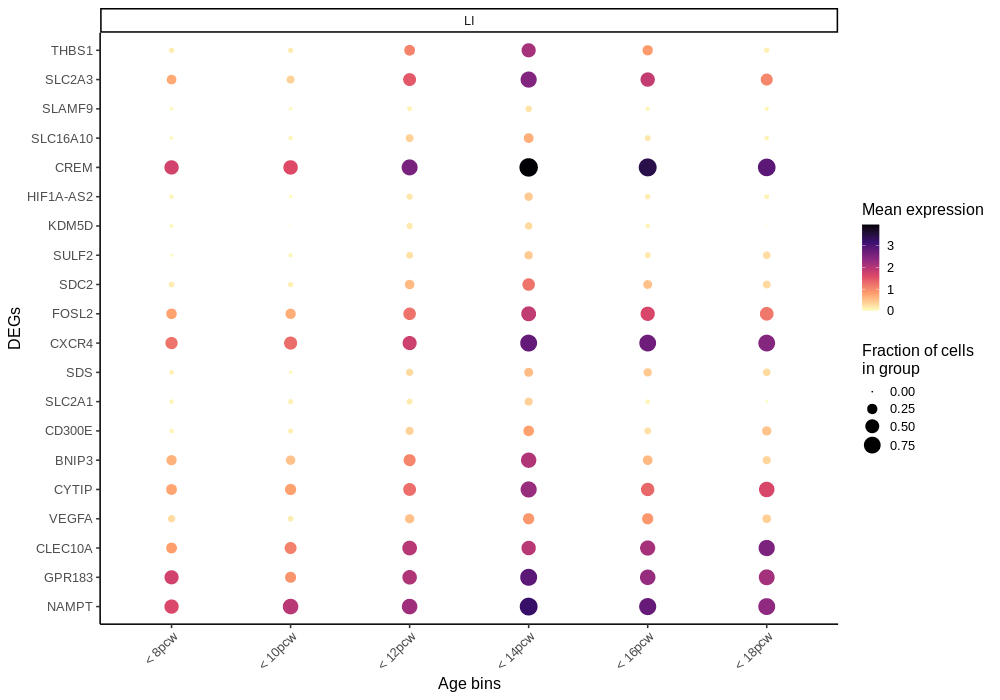

In [200]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl2 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl2 
# +
#  ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.png"), width=6, height=8) + 
#     ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.pdf"), width=6, height=8)

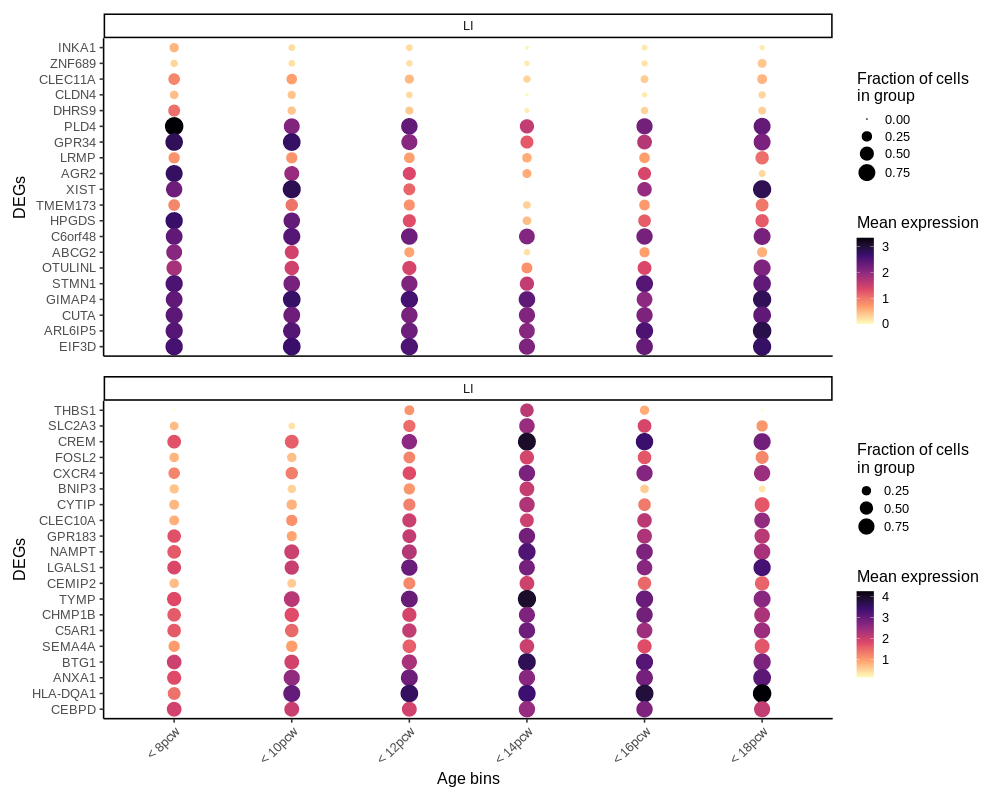

In [106]:
%%R -w 1000 -h 800
((pl1 + remove_x_axis()) / pl2) +
 ggsave(paste0(figdir, "MACIV_LI_cells_DEGs.png"), width=7, height=12) + 
    ggsave(paste0(figdir, "MACIV_LI_cells_DEGs.pdf"), width=7, height=12) 


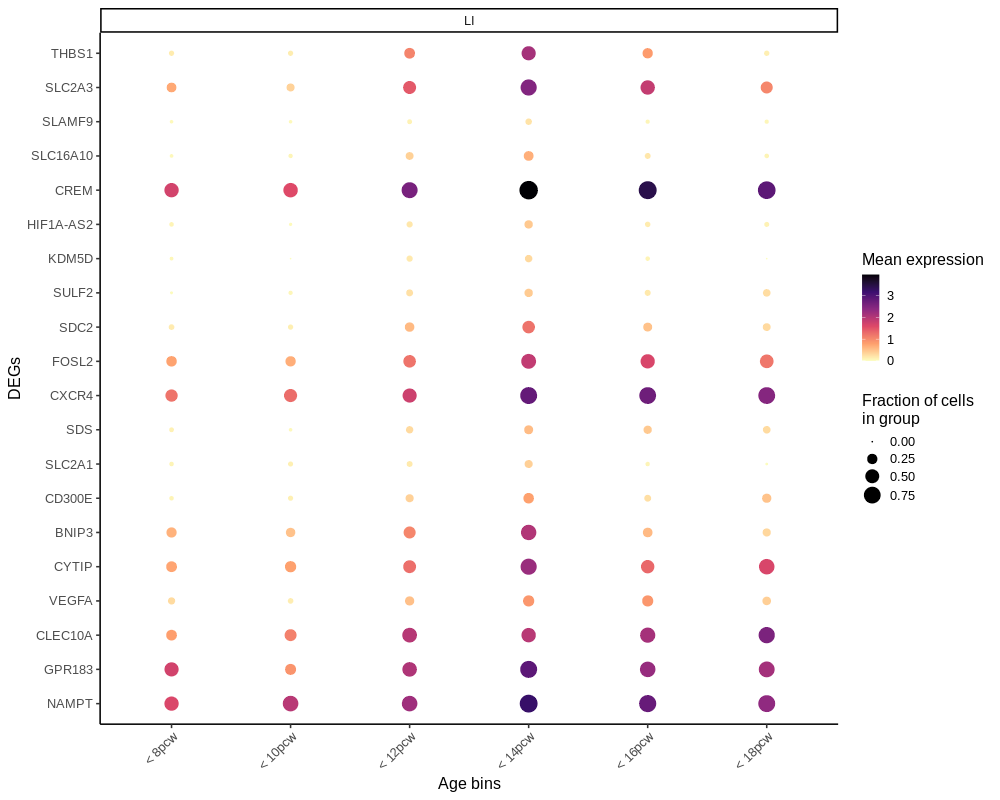

In [201]:
%%R -w 1000 -h 800
( pl2) +
 ggsave(paste0(figdir, "MACIV_late_LI_cells_DEGs.png"), width=6, height=8) + 
    ggsave(paste0(figdir, "MACIV_late_LI_cells_DEGs.pdf"), width=6, height=8) 


#### Mac IV in liver

In [214]:
query_sets = [
    (["MACROPHAGE_V"],["LI"], "signif_early"), 
    (["MACROPHAGE_V"],["LI"], "signif_late"), 
]

In [219]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")

In [223]:
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=50,  min_fc=0)
## mean expression
X_df_ls = []
for org in ["LI"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["LI"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


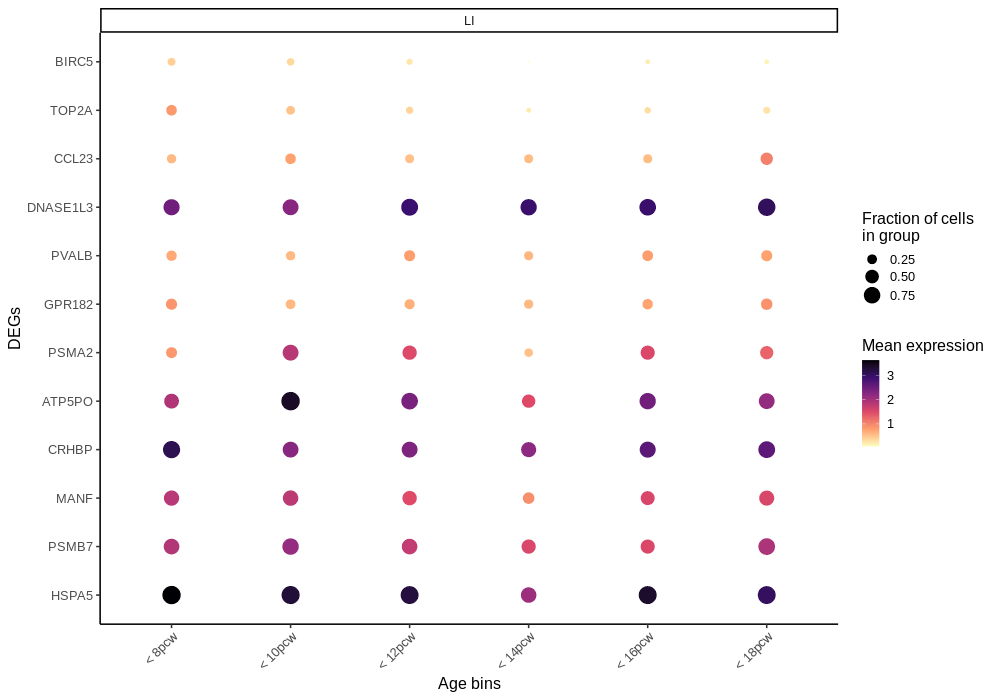

In [224]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl1 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl1 
#  ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.png"), width=6, height=12) + 
#     ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.pdf"), width=6, height=12)

In [217]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


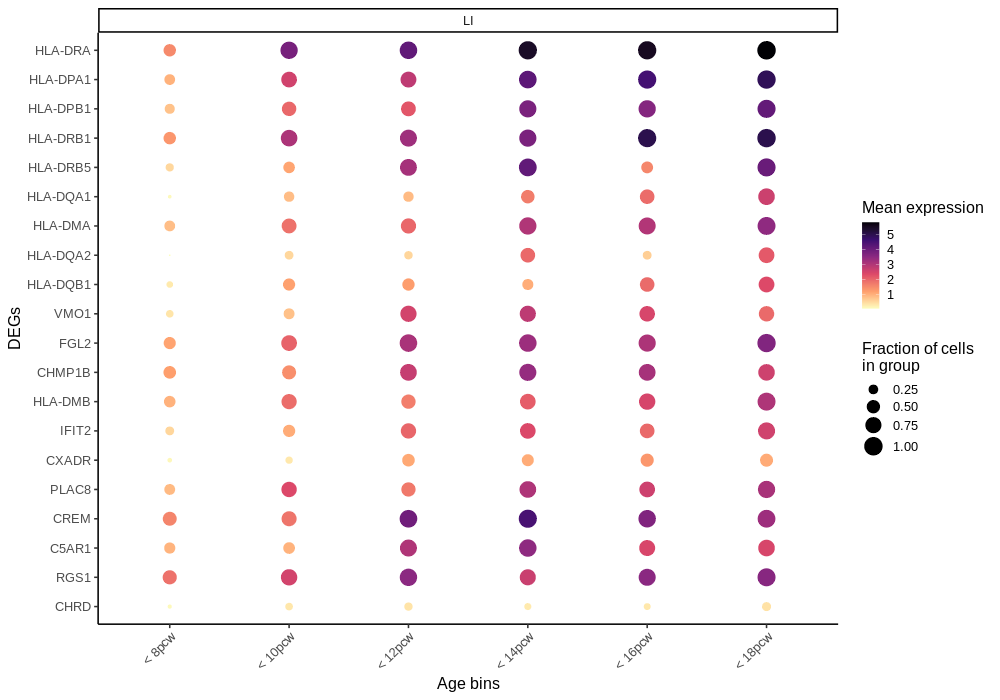

In [218]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl2 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl2 
# +
#  ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.png"), width=6, height=8) + 
#     ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.pdf"), width=6, height=8)

#### Late DCs in liver

In [107]:
query_sets = [
    (["DC1"],["LI"], "signif_late"), 
    (["DC2"],["LI"], "signif_late"), 
    (["DC3"],["LI"], "signif_late")
]

In [108]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in ["LI"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in ["LI"]:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


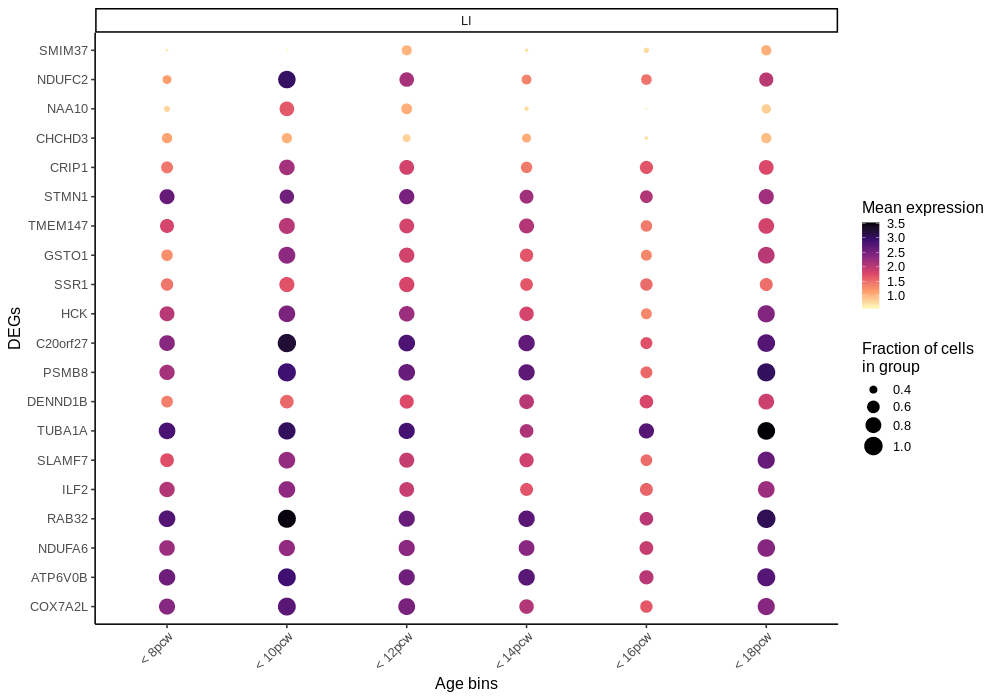

In [109]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl1 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl1 
#  ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.png"), width=6, height=12) + 
#     ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.pdf"), width=6, height=12)

In [110]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


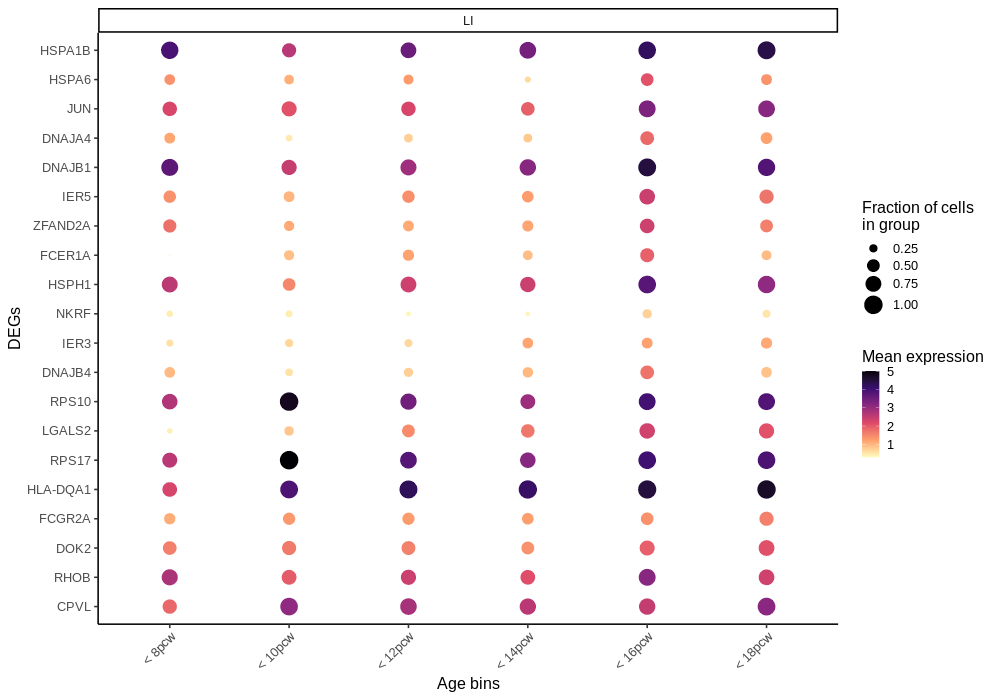

In [111]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl2 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl2 
# +
#  ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.png"), width=6, height=8) + 
#     ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.pdf"), width=6, height=8)

In [112]:
subset_anno, subset_organ, condition = query_sets[2]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


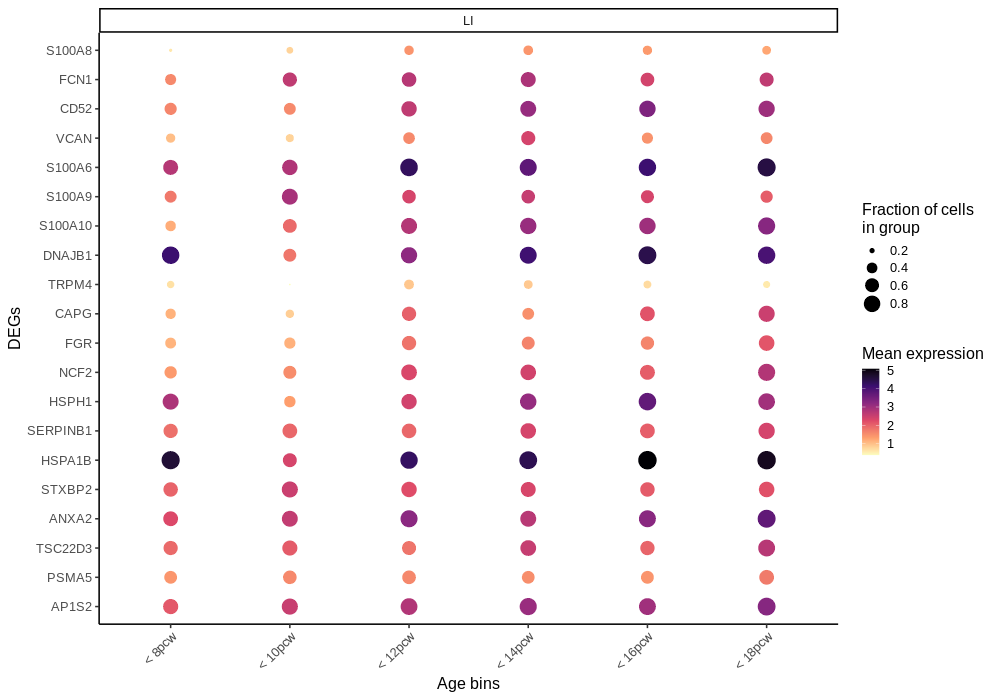

In [113]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl3 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl3
# +
#  ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.png"), width=6, height=8) + 
#     ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.pdf"), width=6, height=8)

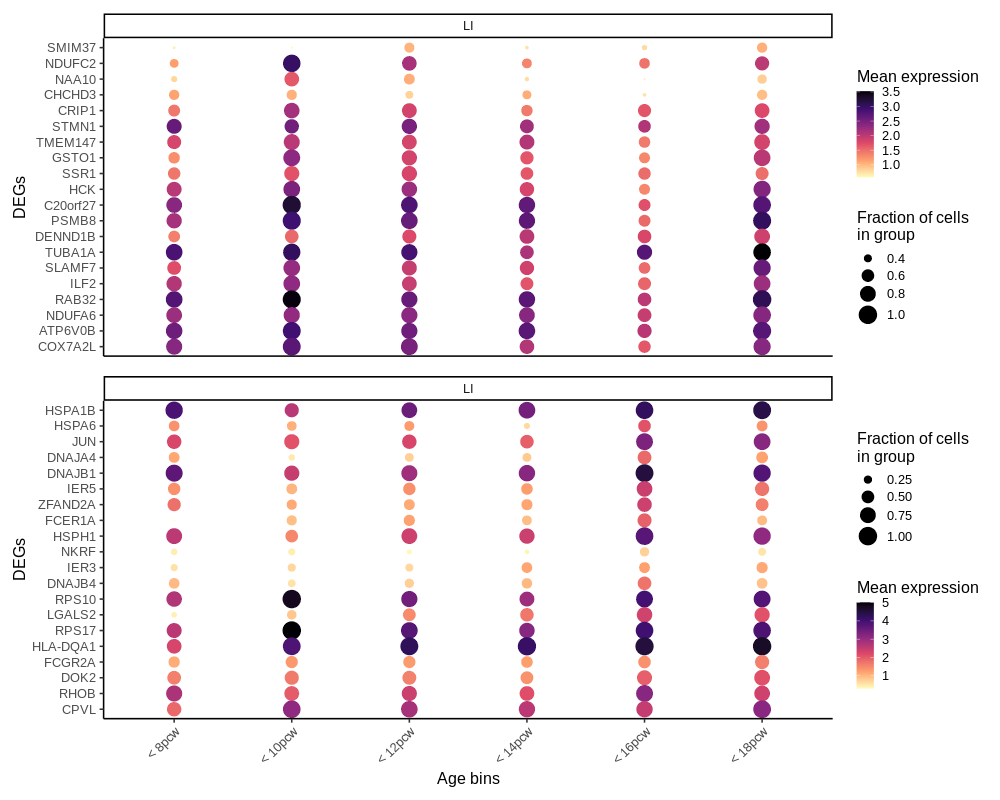

In [114]:
%%R -w 1000 -h 800
((pl1 + remove_x_axis()) / pl2) +
 ggsave(paste0(figdir, "DC1_LI_cells_DEGs.png"), width=7, height=12) + 
    ggsave(paste0(figdir, "DC1_LI_cells_DEGs.pdf"), width=7, height=12) 


#### Late DCs in Thymus

In [95]:
query_sets = [
    (["DC1"],["TH"], "signif_late")
]

In [99]:
subset_anno, subset_organ, condition = query_sets[0]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=30,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


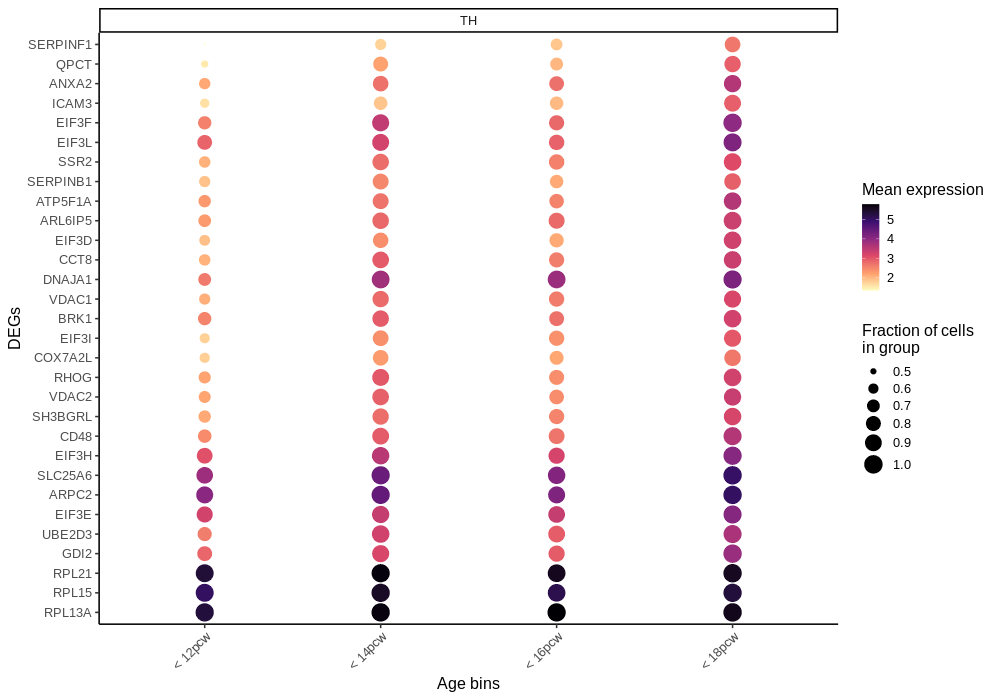

In [100]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl1 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl1 
#  ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.png"), width=6, height=12) + 
#     ggsave(paste0(figdir, "SK_MAC_III_cells_DEGs.pdf"), width=6, height=12)

In [91]:
subset_anno, subset_organ, condition = query_sets[1]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


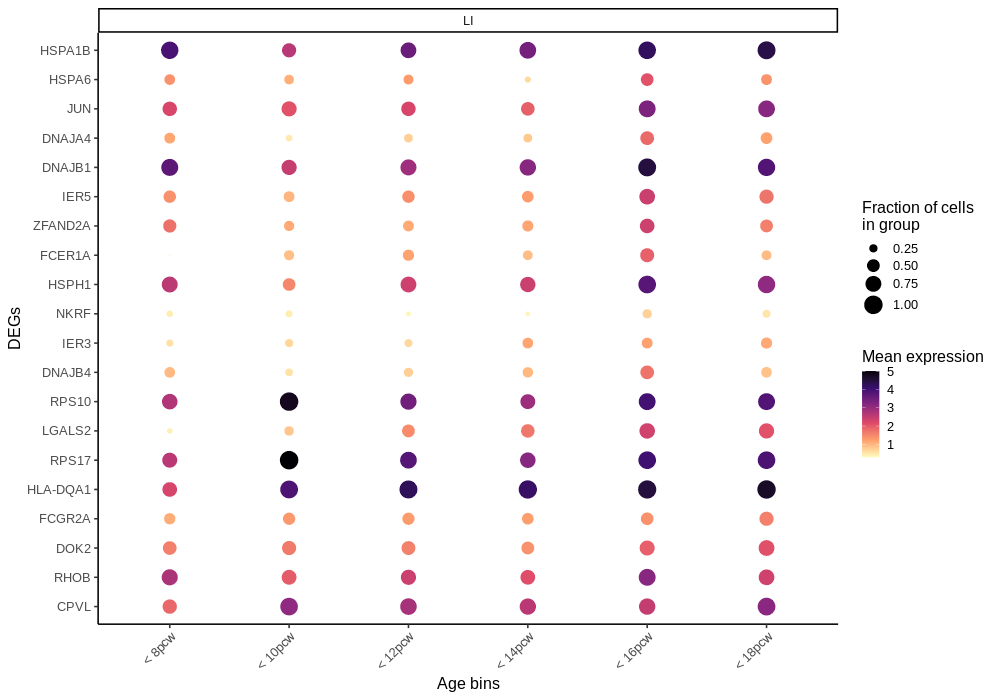

In [92]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl2 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl2 
# +
#  ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.png"), width=6, height=8) + 
#     ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.pdf"), width=6, height=8)

In [93]:
subset_anno, subset_organ, condition = query_sets[2]
test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition, 
                                  max_frac=0.7,
                                  test_type='vs_rest')
test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
genes = get_top_DEGs(dge_df, FC_direction = 1, n_genes=20,  min_fc=0.25)
## mean expression
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='m')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
X_pl_df = pd.concat(X_df_ls)

## n_cells expressing
X_df_ls = []
for org in subset_organ:
    pbulk_adata = anndata2pseudobulk(test_adata[test_adata.obs['organ'] == org], group_by=["age_bins"], agg='n')[:,genes]
    X_df = pd.DataFrame(pbulk_adata.X.toarray())
    X_df.columns = genes
    X_df.index = pbulk_adata.obs_names
    X_df['n_cells'] = pbulk_adata.obs["n_cells"]
    X_df['organ'] = org
    X_df['age_bins'] = X_df.index
    X_df_ls.append(X_df)
N_pl_df = pd.concat(X_df_ls)

Trying to set attribute `.obs` of view, copying.


Trying to set attribute `.obs` of view, copying.
... storing 'test_condition' as categorical
Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


Joining, by = c("n_cells", "organ", "age_bins", "gene")


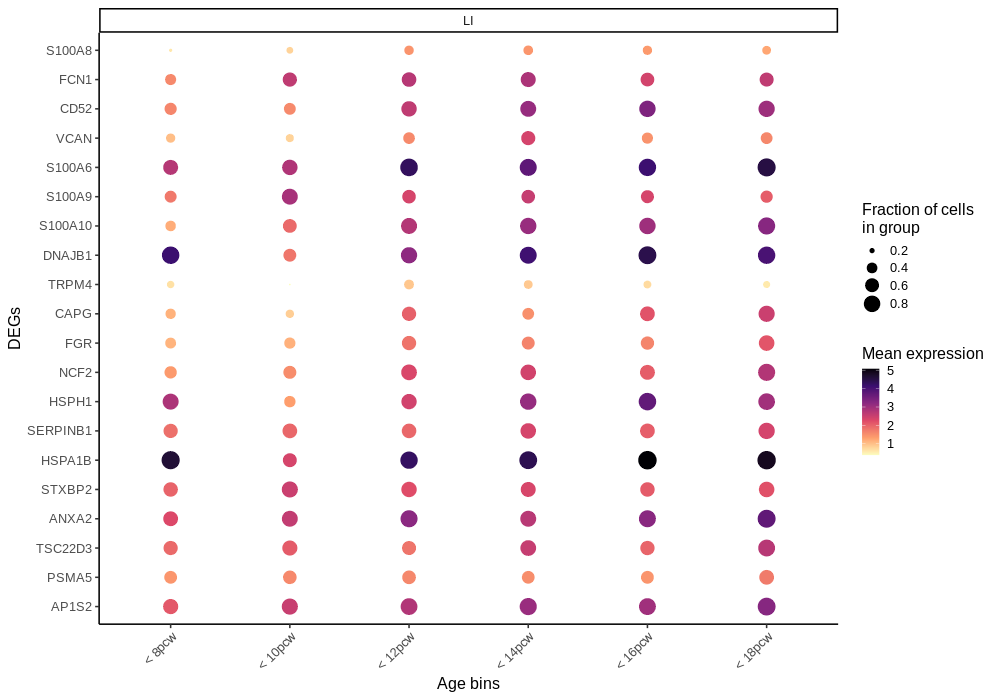

In [94]:
%%R -i X_pl_df -i N_pl_df -i genes -i cut_labels_4 -w 1000 -h 700

pl3 <- left_join(
    X_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='mean_gex'),
    N_pl_df %>% pivot_longer(cols=genes, names_to="gene", values_to='n_cells_gex')
    ) %>%
    mutate(gene=factor(gene, levels=rev(genes))) %>%
    mutate(age_bins = as.character(cut_labels_4)[as.numeric(age_bins) + 1]) %>%
    mutate(age_bins = factor(age_bins, levels=cut_labels_4)) %>%
    mutate(organ = factor(organ, levels=c("YS", "LI", "SK", "TH", "SP", "BM", "MLN", "KI", "GU"))) %>%
    ggplot(aes(age_bins, gene)) +
    geom_point(aes(size=n_cells_gex/n_cells, color=mean_gex)) +
    scale_size(range=c(0,8), name='Fraction of cells\nin group') +
    facet_grid(.~organ, space="free", scales="free") +
#     scale_color_distiller(palette='Reds', direction=1, name='Mean expression') +
    scale_color_viridis_c(option='magma', direction=-1, name='Mean expression') +
    xlab("Age bins") + ylab("DEGs") +
    theme_classic(base_size=16) +
    theme(axis.text.x=element_text(angle=45, hjust=1))

pl3
# +
#  ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.png"), width=6, height=8) + 
#     ggsave(paste0(figdir, "SK_MAC_I_cells_DEGs.pdf"), width=6, height=8)

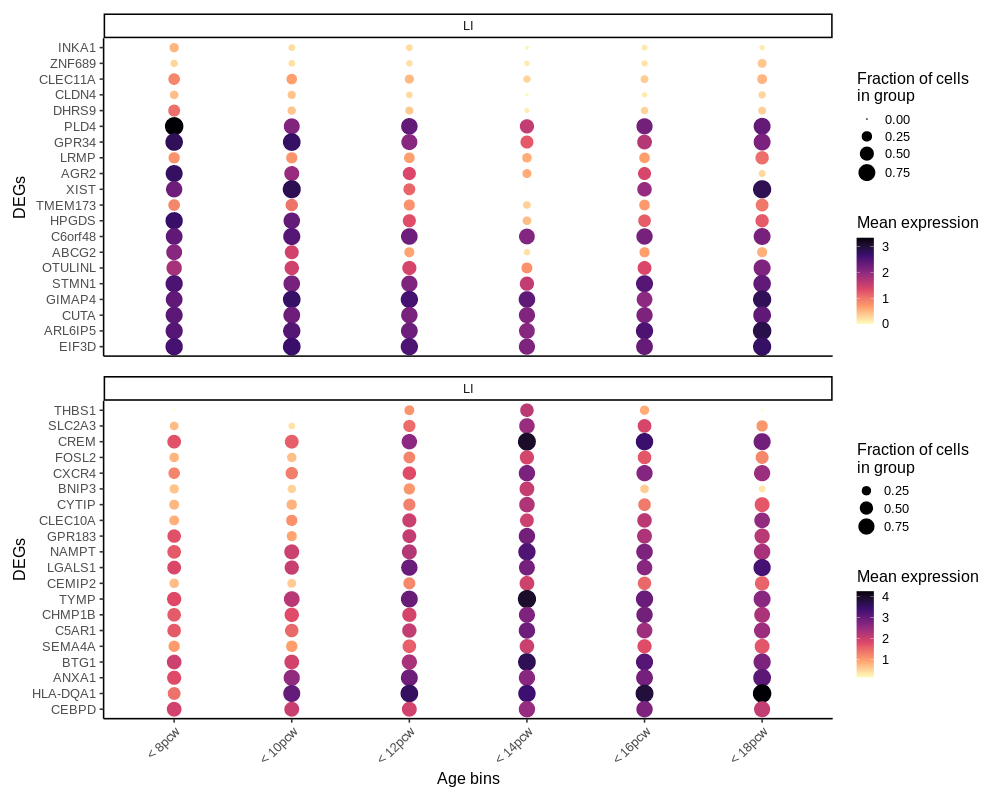

In [87]:
%%R -w 1000 -h 800
((pl1 + remove_x_axis()) / pl2) +
 ggsave(paste0(figdir, "MACIV_LI_cells_DEGs.png"), width=7, height=12) + 
    ggsave(paste0(figdir, "MACIV_LI_cells_DEGs.pdf"), width=7, height=12) 


### Differential expression analysis

Calculate mean expression for each neighbourhood

In [20]:
## Add mean expression for each neighbourhood
nhood_adata = adata.uns["nhood_adata"].copy()
X = adata.X
expr_id = "expr" 
## Aggregate over nhoods -- taking the mean
nhoods_X = X.T.dot(adata.obsm["nhoods"])

from scipy.sparse import csr_matrix
nhoods_X = csr_matrix(nhoods_X / adata.obsm["nhoods"].toarray().sum(0))
adata.uns["nhood_adata"].obsm[expr_id] = nhoods_X.T

Label neighbourhoods by outcome in each organ test

In [52]:
long_org_fc = pl_df.copy()
alpha=0.1

In [53]:
signif_early = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] < 0)
signif_late = (long_org_fc['SpatialFDR'] < alpha) & (long_org_fc['logFC'] > 0)
not_signif = (long_org_fc['SpatialFDR'] >= alpha)

long_org_fc['test_label'] = "not_signif"
long_org_fc.loc[signif_late, "test_label"] = "signif_late"
long_org_fc.loc[signif_early, "test_label"] = "signif_early"

In [54]:
def test_DGE(adata, long_org_fc, subset_organ, subset_anno, alpha=0.1, condition='signif_late'):
    '''
    Extract cells in neighbourhoods with significant enrichment in early or late cells and use 
    simple scanpy test to find markers VS the rest of cells in the same organ/annotation.
    
    Params:
    -------
    - long_org_fc: long format dataframe containing milo testing results
    - subset_organ: list of organs to test in
    - subset_anno: list or cell types to test in (values or `anno_lvl_2_final_clean`)
    - alpha: significance FDR threshold (default=0.1)
    - condition: which condition to compare to the rest? (either `signif_late` or `signif_early`)

    '''
    keep_nhoods_df = long_org_fc[(long_org_fc.organ.isin(subset_organ)) & (long_org_fc.nhood_anno.isin(subset_anno))][["Nhood", "test_label"]]
    pick_nhoods = keep_nhoods_df[keep_nhoods_df['test_label'] == condition]["Nhood"].astype('int')

    cells_in_nhoods = adata.obsm["nhoods"][:,pick_nhoods].toarray().sum(1) > 0
    cells_in_org = (adata.obs.organ.isin(subset_organ)) & (adata.obs.anno_lvl_2_final_clean.isin(subset_anno))

    test_adata = adata[cells_in_org]

    case_cells = adata[cells_in_org & cells_in_nhoods].obs_names
    test_adata.obs["test_condition"] = 'control'
    test_adata.obs.loc[case_cells, "test_condition"] = 'case'
#     if len(case_cells) < 10:
    sc.tl.rank_genes_groups(test_adata, groupby="test_condition", groups=["case"])
    
    ## Get dataframe of results
    dge_dict = test_adata.uns['rank_genes_groups'].copy()
    dge_dict.pop("params")
    dge_dict = {k:[x[0] for x in dge_dict[k]] for k,v in dge_dict.items()}
    dge_df = pd.DataFrame.from_dict(dge_dict)
    
    return(test_adata, dge_df)

def plot_DGE(test_adata, dge_df, subset_organ, subset_anno, n_genes=30, figsize=[4,10], save=False):
    ## Extract top genes and order by FC
    genes_df = dge_df.sort_values("pvals_adj").iloc[0:n_genes]
    genes = genes_df.sort_values("logfoldchanges", ascending=False)["names"]

    test_adata.obs["age_bins"] = test_adata.obs["age_bins"].astype("str")
    pl_title = ''.join(subset_anno) + " - " + ''.join(subset_organ) 
    ax = sc.pl.dotplot(test_adata, genes, groupby='age_bins', dendrogram=False, cmap="Reds", 
    #                      standard_scale="var"
                         return_fig=False, title=pl_title, swap_axes=True, show=False, 
                               figsize=figsize 
                        );
    fig = plt.gcf()
    plot_ax = fig.axes[1]
    cbar_ax = fig.axes[-1]
    cbar_ax.set_title("Median\nexpression");
    bins_labels = dict(zip([str(x) for x in range(len(cut_labels_4))], cut_labels_4))
    plot_ax.set_xticklabels([bins_labels[x.get_text()] for x in plot_ax.get_xticklabels()], 
                            rotation=45, ha="right");
    if save:
        fig.savefig(figdir + pl_title + '_stacked_violin.png', bbox_inches="tight")

Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical
Trying to set attribute `.obs` of view, copying.


... storing 'test_condition' as categorical
... storing 'age_bins' as categorical


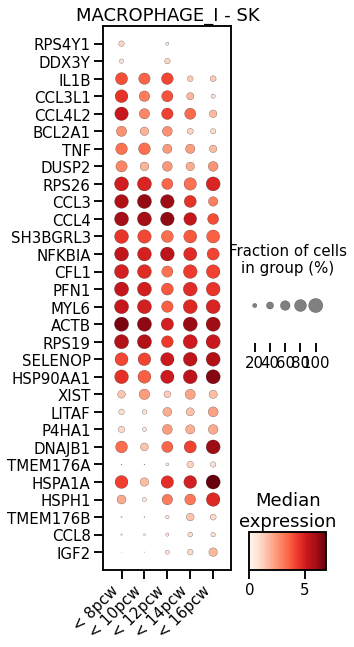

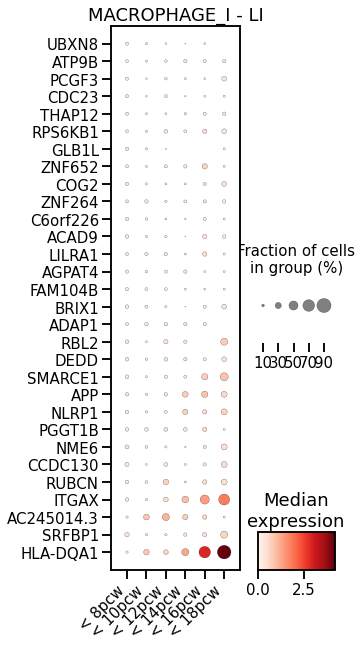

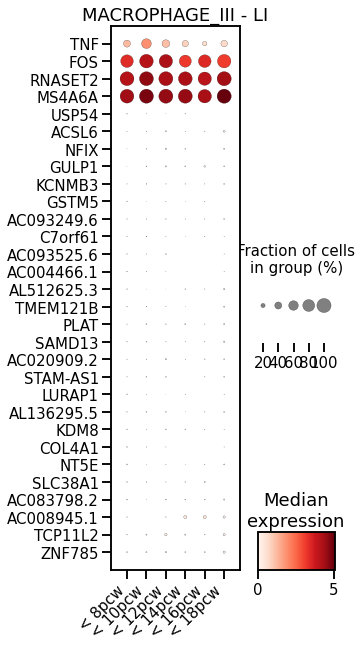

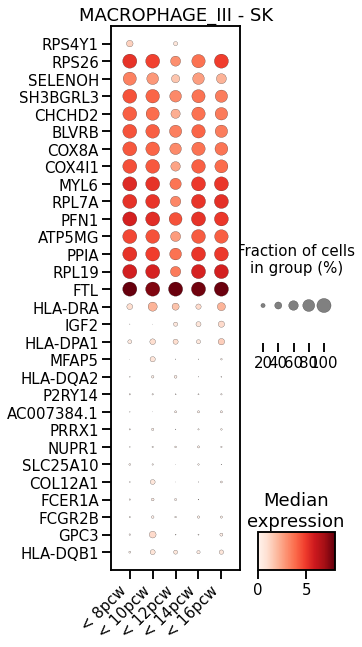

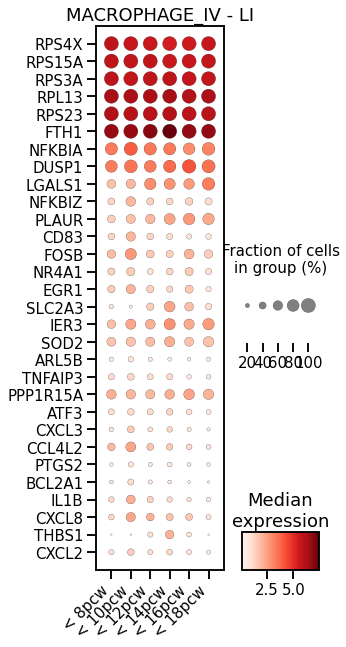

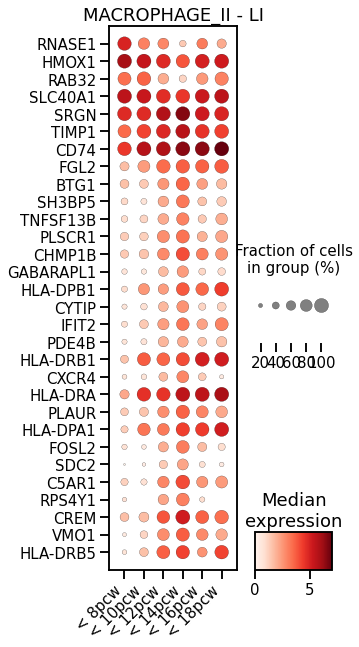

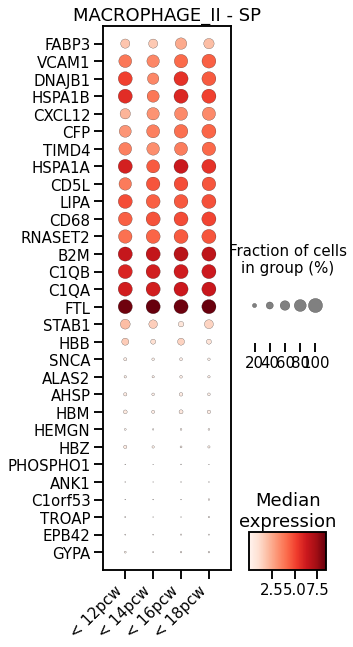

In [55]:
query_sets = [
    (["MACROPHAGE_I"],["SK"], "signif_early"), 
    (["MACROPHAGE_I"],["LI"], "signif_early"), 
    (["MACROPHAGE_III"],["LI"], "signif_early"), 
    (["MACROPHAGE_III"],["SK"], "signif_early"), 
    (["MACROPHAGE_IV"],["LI"], "signif_early"), 
    (["MACROPHAGE_II"],["LI"], "signif_early"), 
    (["MACROPHAGE_II"],["SP"], "signif_late"), 
]

dge_results = []
for subset_anno, subset_organ, condition in query_sets:
    test_adata, dge_df = test_DGE(adata, long_org_fc, subset_organ, subset_anno, condition=condition)
    plot_DGE(test_adata, dge_df, subset_organ, subset_anno, save=True)
    dge_results.append([subset_anno, subset_organ, condition, test_adata, dge_df])

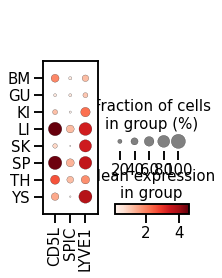

In [62]:
sc.pl.dotplot(adata[adata.obs["anno_lvl_2_final_clean"] == "MACROPHAGE_II"], ['CD5L',"SPIC",'LYVE1'], groupby='organ')

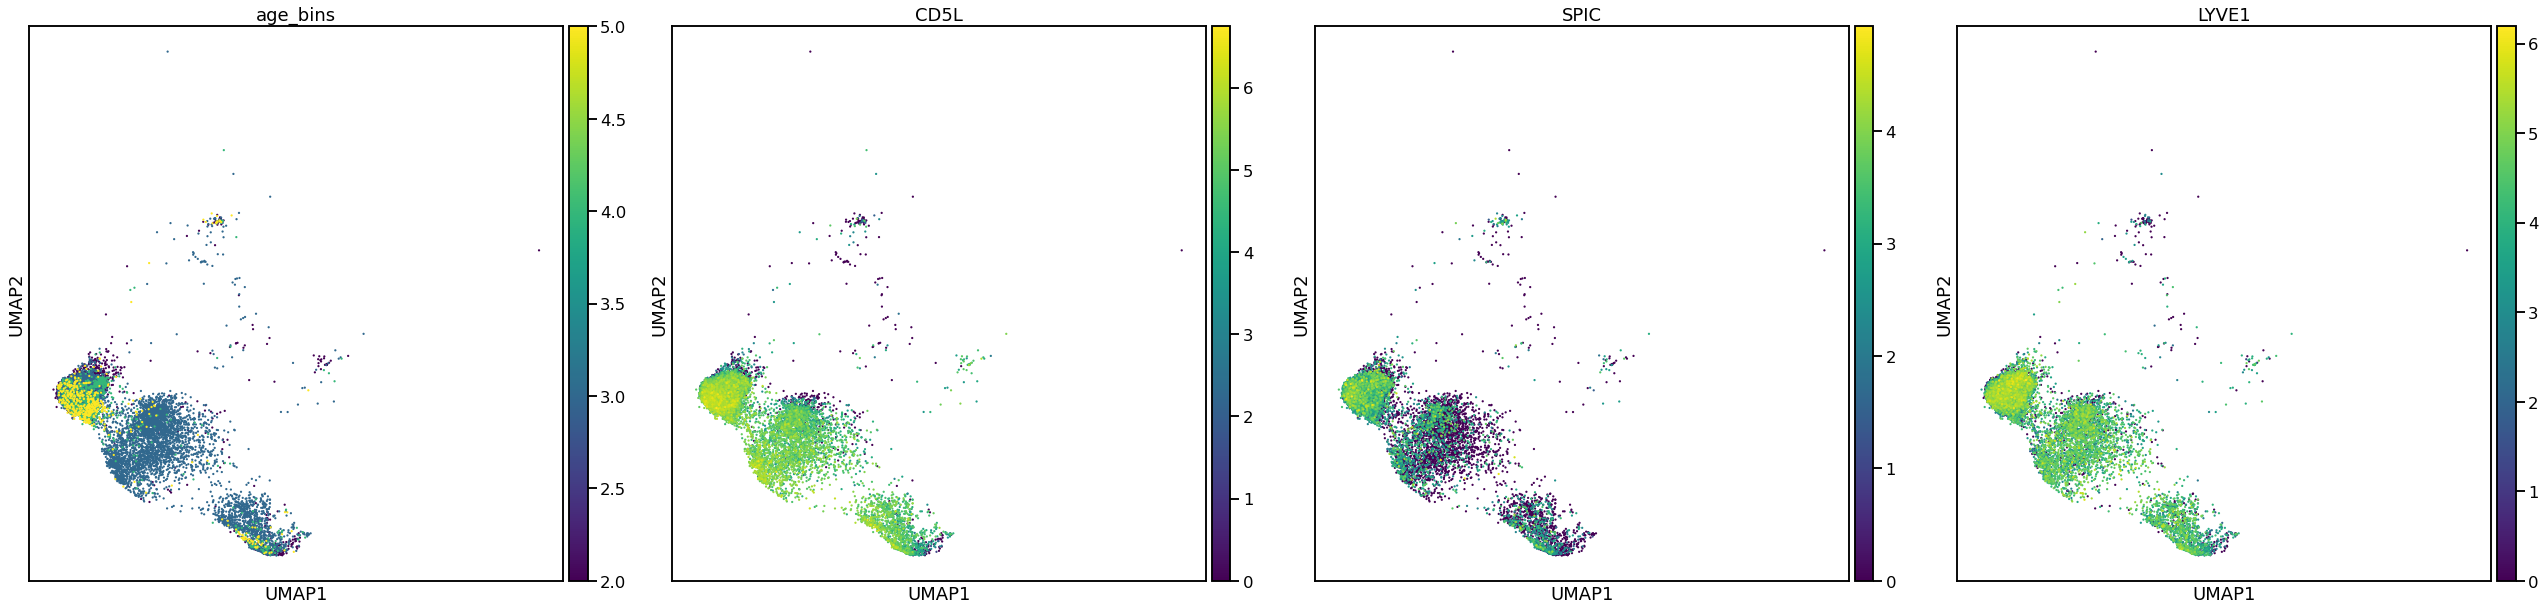

In [69]:
sc.pl.umap(adata[(adata.obs["anno_lvl_2_final_clean"] == "MACROPHAGE_II") & (adata.obs["organ"] == "SP")], color=['age_bins','CD5L',"SPIC",'LYVE1'], size=20)

In [56]:
import pickle
with open(data_dir + 'tmp/DGE_milo_MYELOID.pickle', 'wb') as fout:
    pickle.dump(dge_results, fout)

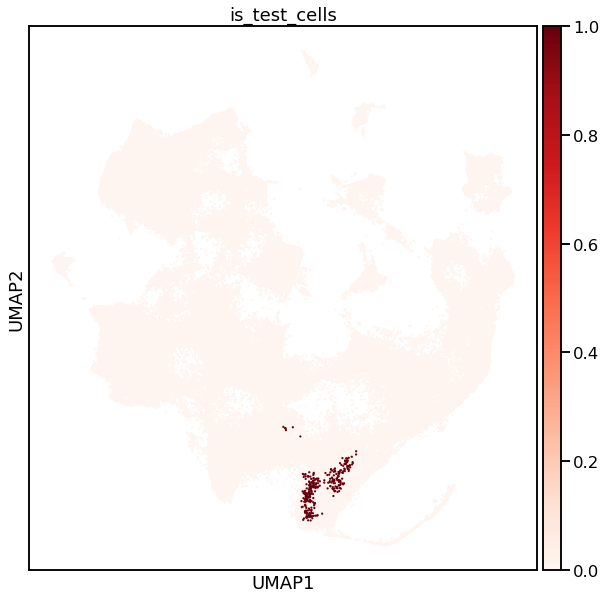

In [554]:
test_cells = test_adata.obs_names[test_adata.obs.test_condition=="case"]
adata.obs["is_test_cells"] = adata.obs_names.isin(test_cells).astype("int")

sc.pl.umap(adata, color=["is_test_cells"], size=20, cmap="Reds")

---
---

### Junk n snippets

In [233]:
import rpy2.robjects.pandas2ri
import rpy2.robjects.numpy2ri
from rpy2.robjects.packages import STAP

def _test_lognormal_dge_limma(test_adata, model_contrasts="test_labelsignif_early-test_labelsignif_late"):
    r_fct_string = '''
    library(limma)
    perform_lognormal_dge <- function(exprs.data, 
                                      covariate, 
                                      design = "~0+test_label",
                                      gene.offset=TRUE,
                                      model_contrasts=NULL, 
                                      n.coef=NULL){

        test.model = model.matrix(as.formula(design), data=as.data.frame(covariate))

        if(isTRUE(gene.offset)){
            n.gene <- apply(exprs.data, 2, function(X) sum(X > 0))
            old.col <- colnames(test.model)
            if(all(test.model[, 1] == 1)){
                test.model <- cbind(test.model[, 1], n.gene, test.model[, c(2:ncol(test.model))])
                colnames(test.model) <- c(old.col[1], "NGenes", old.col[c(2:length(old.col))])
            } else{
                test.model <- cbind(n.gene, test.model)
                colnames(test.model) <- c("NGenes", old.col)
            }
        }

        i.fit <- lmFit(exprs.data, test.model)
        if(!is.null(model_contrasts)){
            mod.constrast <- makeContrasts(contrasts=model_contrasts, levels=test.model)
            i.fit <- contrasts.fit(i.fit, contrasts=mod.constrast)
            i.fit <- eBayes(i.fit, trend=TRUE)
            i.res <- as.data.frame(topTreat(i.fit, number = Inf, sort.by = "p", p.value = 1))
        } else{
            i.fit <- eBayes(i.fit, trend=TRUE)
            if(is.null(n.coef)){
                n.coef <- ncol(test.model)
            }

            i.res <- as.data.frame(topTreat(i.fit, coef=ncol(test.model), number = Inf, sort.by = "none", p.value = 1))
        }
        return(data.frame(i.res))
    }
    '''

    r_pkg = STAP(r_fct_string, "r_pkg")

    expr = test_adata.X.toarray()
    covariate = test_adata.obs[["test_label"]]
    gene_names = test_adata.var_names

    # CONVERT PYTHON NUMPY MATRICES TO R OBJECTS
    r_X = map(rpy2.robjects.numpy2ri, expr)
    r_cov = map(rpy2.robjects.pandas2ri, covariate)

    # PASS R OBJECTS INTO FUNCTION (WILL NEED TO EXTRACT DFs FROM RESULT)
    p_res = r_pkg.perform_lognormal_dge(expr.T, covariate, model_contrasts=model_contrasts)

    results = pd.DataFrame(p_res)
    results.index = gene_names

    return(results.sort_values("adj.P.Val"))

def label_early_and_late_nhoods(long_org_fc, subset_anno, 
                                subset_organ=None,
                                fc_cutoff = 0
                               ):
    if subset_organ is not None:
        keep_nhoods = long_org_fc['nhood_anno'].isin(subset_anno) & long_org_fc['organ'].isin(subset_organ)
    else:
        keep_nhoods = long_org_fc['nhood_anno'].isin(subset_anno)
    ## Take mean fold change across organs
    mean_fc = long_org_fc[keep_nhoods].groupby('Nhood').mean()["logFC"]

    ## Split based on fold-change cutoff
    late_nhoods = mean_fc > fc_cutoff
    early_nhoods = mean_fc < - fc_cutoff
    
    late_ixs = mean_fc.index[late_nhoods]
    early_ixs = mean_fc.index[early_nhoods]

    return(late_ixs, early_ixs, mean_fc)
    

In [234]:
def run_early_late_dge(long_org_fc, 
                       subset_anno,
                       subset_organ=None,
                       min_lfc=0.25,
                       min_n_nhoods=50):

    late,early,_ = label_early_and_late_nhoods(long_org_fc, subset_anno=subset_anno, subset_organ=subset_organ)
    nhood_adata = adata.uns["nhood_adata"].copy()
    anno_nhood_adata = nhood_adata[nhood_adata.obs["nhood_annotation"].isin(subset_anno)]

    test_label = ["early" if int(x) in (early -1 ) else "late" if int(x) in (late - 1) else np.nan for x in anno_nhood_adata.obs_names]
    anno_nhood_adata.obs["test_label"] = pd.Series(test_label).astype("category").values

    X_mat = anno_nhood_adata.obsm["expr"]
    test_adata = anndata.AnnData(X=X_mat, obs=anno_nhood_adata.obs, var=adata.var)
    test_adata = test_adata[~test_adata.obs["test_label"].isna()]

    ## Test differential expression
    dge_limma_df = _test_lognormal_dge_limma(test_adata)

    ## Extract top genes
    top_dge = dge_limma_df[(dge_limma_df['logFC'].abs() > min_lfc) & (dge_limma_df["adj.P.Val"] < 0.01)]

    top_early = top_dge[top_dge.logFC < 0].index
    top_late = top_dge[top_dge.logFC > 0].index
    
    params = {'subset_anno':subset_anno, "subset_organ":subset_organ, "min_lfc":min_lfc, 'min_n_nhoods':min_n_nhoods}
    return(top_early, top_late, params)

Test for DGE in interesting cell types

In [ ]:
import json

query_sets = [
    (["CD14+_MACROPHAGE"],["SK", "LI"]), 
    (["ILC3"],None), 
    (["HSC_MPP"], ["LI"]), 
    (["CD4+T", 'CD8+T'], ["TH"]),
    (['TREG'], ["TH"]),
    (['ABT(ENTRY)'], ["TH"]),
    (["DP(Q) T CELL", 'DP(P) T CELL'], ["TH"]),
    (["DN(Q) T CELL", 'DN(P)_DN(EARLY) T CELL'], ["TH"]),
    (["LATE_ERYTHROID", "MID_ERYTHROID", "EARLY_ERYTHROID"], ["LI"])
]

dge_results = []
for anno,org in query_sets:
    print(anno)
    early,late,params = run_early_late_dge(long_org_fc, anno, subset_organ=org, min_lfc=0.5)
    params["early_genes"] = early
    params["late_genes"] = late
    dge_results.append(params)

## Save to json
for i in range(len(dge_results)):
    dge_results[i]["early_genes"] = dge_results[i]["early_genes"].tolist()
    dge_results[i]["late_genes"] = dge_results[i]["late_genes"].tolist()
with open(data_dir + 'tmp/DGE_early_late_nhoods.json', 'w') as fout:
    json.dump(dge_results, fout)

['NK']


Trying to set attribute `.obs` of view, copying.


['ILC3']


Trying to set attribute `.obs` of view, copying.


In [ ]:
## Extract top genes
top_dge = dge_limma_df[(dge_limma_df['logFC'].abs() > min_lfc) & (dge_limma_df["adj.P.Val"] < 0.01)]

top_early = top_dge[top_dge.logFC < 0].index
top_late = top_dge[top_dge.logFC > 0].index

params = {'subset_anno':subset_anno, "subset_organ":subset_organ, "min_lfc":min_lfc, 'min_n_nhoods':min_n_nhoods}
return(top_early, top_late, params)